In [6]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
%matplotlib inline
from bs4 import BeautifulSoup
import requests
from datetime import datetime as dt
import logging
from concurrent.futures import ThreadPoolExecutor
FORMAT = '%(asctime)-15s %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
import matplotlib.cm as cm
from sklearn import linear_model

### Testing

In [307]:
test_links = ['https://www.rottentomatoes.com/m/spider_man_into_the_spider_verse',
             'https://www.rottentomatoes.com/m/black_panther_2018']

In [308]:
# from datetime import datetime as dt

# review_text = []
# review_score = []

# ts = dt.now().isoformat()
# print(ts)

# for link in test_links:
# #     url = link + '/reviews/?page=1&type=user'
# #     result = requests.get(url)
# #     soup = BeautifulSoup(result.content)
# #     page_info = soup.find_all('span', {'class': 'pageInfo'})
# #     num_pages = int(page_info[0].get_text().split("of",1)[1])

#     for page in range(1,51):
#         url = link + '/reviews/?page=' + str(page) + '&type=user'
#         result = requests.get(url)
#         soup = BeautifulSoup(result.content)
#         reviews = soup.find_all('div', {'class': 'col-xs-16'})

#         for review in reviews:
#             # find the review text for each review
#             text = review.find_all('div', {'class': 'user_review'})
#             review_text.append(text[0].get_text())

#             # get the review score first by finding any halfs and then looping through the glyph stars and counting them
#             count = 0
#             if review.get_text()[2] == '½':
#                 count += 0.5
#             else:
#                 pass

#             rev_score = review.find_all('span', {'class': 'glyphicon'})
#             for rev in rev_score:
#                 count += 1
#             review_score.append(count)

# ts = dt.now().isoformat()
# print(ts)

In [309]:
# test_audience_reviews = []
# test_audience_reviews.append((review_text,review_score))

### Scraping
First, scrape wikipedia film info by year page to get the bulk titles for training the model and output to csv. Then, take those titles and scrape bomojo, rottentomatoes, metacritic, maybe wikipedia pageviews (if you can get data prior to 2015), and wikipedia films-specific info as well. That way, down the road, you can run the scraper for any wikipedia title you're interested without running the whole pipeline.

In [4]:
# STEP 1: get wikipedia links to feed into scraper
# not necessary for new wikipedia titles run after initial training of model
class get_wiki_links:
    def __init__(self):
        self.wiki_titles = []
        self.wiki_urls = []
        self.wiki_api_titles = []
    
    def fit(self,start_year,end_year):
        logging.info('Getting wikipedia links...')
        self.get_links(start_year, end_year)
        logging.info('Clean wikipedia URLs...')
        self.clean_wiki_urls()
        logging.info('Setting up dataframes...')
        self.data_frames()
        logging.info('Complete!')
           
    def get_links(self,start_year,end_year):
        for year in range(start_year,end_year + 1):
            url = 'https://en.wikipedia.org/wiki/' + str(year) + '_in_film'
            result = requests.get(url)
            soup = BeautifulSoup(result.content, 'html.parser')
            links = soup.find_all("table", { "class" : "wikitable sortable" })

            for link in links:
                for lin in link.find_all('i'):
                    for i in lin.find_all('a'):
                        self.wiki_titles.append(i.get_text())
                        self.wiki_urls.append(i.get('href'))

    def clean_wiki_urls(self):    
        for url in self.wiki_urls:
            org_url = url
            url = url.replace('%27', "'")
            url = url.replace('%26', '&')
            url = url.replace('%28', '(')
            url = url.replace('%29', ')')
            url = url.replace('%3F', '?')
            url = url.replace('%E2%80%93', '-')
            url = url.replace('%C3%A9', 'é')
            url = url.replace('%C3%A8', 'è')
            url = url.replace('%2C', ',')
            url = url.replace('%C4%97', 'ė')
            url = url.replace('%C3%A0', 'à')
            url = url.replace('%C3%BC', 'ü')
            url = url.replace('%C3%A1', 'á')
            self.wiki_api_titles.append((org_url,url[6:]))

    def data_frames(self):
        #create dataframe for wiki link and titles, not really needed, might remove
        self.df_wiki_links = pd.DataFrame({'wiki_url': self.wiki_urls,
                                           'wiki_title': self.wiki_titles})
        df_wiki_links_clean = pd.DataFrame(self.wiki_api_titles,columns=['org_wiki_url','clean_wiki_url'])
        self.df_wiki_links = self.df_wiki_links.merge(df_wiki_links_clean,left_on='wiki_url',right_on='org_wiki_url',how='left')
        self.df_wiki_links.to_csv('wikipedia_links.csv',sep=',',index=False)

In [311]:
# STEP 2: scrape info from third-party sites to eventually merge into one model

class box_office_info_scrape:
    def __init__(self):
        self.list_dicts = []
        self.title_list = []
        self.rottentomatoes_scores = []
        self.metacritic_scores = []
        self.bomojo_info = []
        self.rt_audience_review = []
    
    # fit function to run all other functions with status updates through process
    def fit(self, urls, workers):
        logging.info('Getting wikipedia info from wiki pages...')
        self.get_wiki_info(urls)
        logging.info('Setting up initial dataframes...')
        self.data_frames_early()
#         logging.info('Getting wikipedia search volume...')
#         self.get_wiki_search_vol()
        logging.info('Getting box office mojo information...')
        self.bomojo()
        logging.info('Getting RT critic scores...')
        self.get_RT_critic_scores()
        logging.info('Getting RT audience scores...')
        self.crawl(workers)
        logging.info('Getting metacritic scores...')
        self.crawl_metacritics(workers)
        logging.info('Setting up final dataframes...')
        self.data_frames_final()
        logging.info('Completed!')
    
    
    def get_wiki_info(self, urls):
        for url in urls:
            result = requests.get('https://en.wikipedia.org/' + url)
            soup = BeautifulSoup(result.content)
#             info = soup.find_all('table', {'class': 'infobox'})
            
#             # get category title like directed by, studio, boxoffice, etc.
#             # categories differ by title/url so I can't just ask for the 5th or 6th element to get what I want
#             category_info = []
#             try:
#                 category = info[0].find_all('th', {'scope' : 'row'})
#                 for cat in category:
#                     category_info.append(cat.get_text(strip=True))
#             except:
#                 category_info.append(None)

#             # get the actual information associated with each category
#             summary_info = []
#             try:
#                 information = info[0].find_all('td')[1:]
#                 for inf in information:
#                     summary_info.append(inf.get_text('|',strip=True))
#             except:
#                 summary_info.append(None)
#             # add list items to dictionary to re-create structure from wikipedia
#             dictionary = dict(zip(category_info, summary_info))
            dictionary = {}
            dictionary['wiki_url'] = url 

            # get external links for bomojo, imdb, metacritic, rottentomatoes for each title and add it to dictionary
            ext_text = soup.find_all('a', {'class': 'external text'})
            ext_links = []
            for ext in ext_text:
                ext_links.append(ext.get('href'))

            # ad hoc way to parse out links for each title and site
            for link in ext_links:
                if 'mojo' in link:
                    if 'movies' in link:
                        dictionary['bomojo_link'] = link
                    else:
                        pass
                elif 'rottentomatoes' in link:
                    if 'editorial' in link:
                        pass
                    elif 'archive' in link:
                        pass
                    else:
                        dictionary['rottentomatoes_link'] = link
                elif 'metacritic' in link:
                    if 'user' in link:
                        pass
                    elif 'imdb' in link:
                        pass
                    elif 'rotten' in link:
                        pass
                    elif 'archive' in link:
                        pass
                    else:
                        dictionary['metacritic_link'] = link
                elif 'imdb' in link:
                    if 'soundtrack' in link:
                        pass
                    elif 'metacritic' in link:
                        pass
                    elif 'rotten' in link:
                        pass
                    elif 'archive' in link:
                        pass
                    else:
                        dictionary['imdb_link'] = link
                else:
                    pass

            self.list_dicts.append(dictionary)  


    def data_frames_early(self):
        #create dataframe of wikipedia info, needed for bomojo, rottentomatoes and metacritic scrapes
        self.df_wiki_info = pd.DataFrame(self.list_dicts, columns=['wiki_url','bomojo_link','rottentomatoes_link',
                                                                   'metacritic_link', 'imdb_link'])
        self.df_wiki_info = self.df_wiki_info.set_index('wiki_url')
#         self.df_wiki_info = self.df_wiki_info[['wiki_url','Country','Directed by','Distributed by',
#                                                'Distributor','Genre','Produced by','Producer(s)',
#                                                'Release date','Released','Length','Running time',
#                                                'Box office','Budget','Written by',
#                                                'bomojo_link','imdb_link','metacritic_link', 'rottentomatoes_link']]
#         self.df_wiki_info.merge(self.df_wiki_links,left_on='wiki_url',right_on='wiki_url',how='left')
        # remove titles that don't have links to bomojo, rottentomatoes, and metacritic
        self.df_wiki_info = self.df_wiki_info.dropna(subset=['bomojo_link','rottentomatoes_link','metacritic_link'])
        self.df_wiki_info.to_csv('wikipedia_page_info.csv',sep=',',index=True)
        
    
#     # with clean urls, run each title through wikipedia api to get search volume
#     def get_wiki_search_vol(self):
#         p = PageviewsClient(user_agent="<person@organization.org> multiple movie titles")
#         for title in self.df_wiki_links.clean_wiki_url:
#             try:
#                 title_dict = p.article_views('en.wikipedia', title,start='19980101',end='20191231')
#             except:
#                 None
#             self.title_list.append(title_dict)

    # bomojo scrape to get film performance and cleaner release date
    # an issue with some titles where the initial info with release date, distributor, etc. is shifted
    # need to revisit to fix so as not to lose films like Avatar, Harry Potter 7, Lion King, and a few others
    def bomojo(self):
        for index, url in self.df_wiki_info.bomojo_link.iteritems():
            try:
                result = requests.get(url)
                soup = BeautifulSoup(result.content)
                figures = soup.find_all('div', {'class': 'mp_box_content'})

                self.bomojo_info.append((index, url  #bomojo url as primary key
                                         ,soup.find_all('b')[1].get_text(strip=True) #title
                                        ,soup.find_all('b')[5].get_text(strip=True) #genre
                                        ,soup.find_all('b')[4].get_text(strip=True) #domestic release date
                                        ,soup.find_all('b')[7].get_text(strip=True) #rating
                                        ,soup.find_all('b')[3].get_text(strip=True) #studio/distributor
                                        ,figures[0].find_all('b')[1].get_text(strip=True) #domestic box office
                                        ,figures[0].find_all('b')[4].get_text(strip=True) #ww box office
                                        ,figures[1].find_all('td')[1].get_text(strip=True) #opening weekend dom box office
                                        ,figures[1].find_all('td')[7].get_text(strip=True))) # widest release # theaters
            except:
                self.bomojo_info.append((index, url, None, None, None, None, None, None, None, None, None))

                
    def get_RT_critic_scores(self):
#         self.rt_links = [link for link in list(self.df_wiki_info.rottentomatoes_link) if '/m/' in link]
#         self.rt_links = set(self.rt_links) 
        
        for index, url in self.df_wiki_info.rottentomatoes_link.iteritems():
            if url.endswith("/"):
                url_top = url + 'reviews/?type=top_critics'
            else:
                url_top = url + '/reviews/?type=top_critics'
            try:
                result = requests.get(url_top)
                soup = BeautifulSoup(result.content)
                figures = soup.find_all('div', {'class': 'review_table'})

                names = figures[0].find_all('div', {'class': 'critic_name'}) # name of people and journal
                dates = figures[0].find_all('div',{'class': 'review_date subtle small'}) # review date
                review_icons = figures[0].find_all('div',{'class': 'review_icon'})

                for name, date, icon in zip(names,dates,review_icons):
                    name.find_all('a')
                    self.rottentomatoes_scores.append((index, url, name.get_text("|",strip=True),
                                                  date.get_text(strip=True),icon.get('class')[3]))
            except:
                self.rottentomatoes_scores.append((index, url, None, None, None))

                
    def fetch_reviews(self, url, page_number):
        # write a function that takes into a url and page number and returns the reviews
        # use the params built into the get request to handle urls below
        result = requests.get(url + '/reviews/', params={
            'page': page_number,
            'type': 'user'})
        soup = BeautifulSoup(result.content)
        return soup.find_all('div', {'class': 'col-xs-16'})
    
    def extract_audience_data(self, review):
        # find the review text for each review
        text = review.find_all('div', {'class': 'user_review'})
        user_review = text[0].get_text()
        
        # get the review score first by finding any halfs and then looping through 
        # the glyph stars and counting them
        count = 0
        try:
            try:
                review.get_text()[2] == '½'
                count += 0.5
            except:
                pass

            rev_score = review.find_all('span', {'class': 'glyphicon'})
            count += len(rev_score)

#             self.rt_audience_review.append((index, url, text[0].get_text(), count))
            return user_review, count

        except:
#             self.rt_audience_review.append((index, url, None, None))
            return None, None
        
        
    def download_RT_audience_reviews(self, index, url, page_number):
        try:
            for review in self.fetch_reviews(url, page_number):
                review_data = self.extract_audience_data(review)
                self.rt_audience_review.append((index, url, review_data[0], review_data[1]))
        except:
            self.rt_audience_review.append((index, url, None, None))
 

    def crawl(self, workers):
        executor = ThreadPoolExecutor(max_workers=workers)
        for index, url in self.df_wiki_info.rottentomatoes_link.iteritems():
            for page_number in range(1,51):
                executor.submit(self.download_RT_audience_reviews, index, url, page_number)
        executor.shutdown(wait=True)
            
                                                     
#     # fixed the index, url for list of lits, need to update other tables   
#     def get_metacritics_score(self):
#         for index, url in self.df_wiki_info['metacritic_link'].iteritems():
# #         urls = list(set(self.df_wiki_info.metacritic_link))
        
#             if url.endswith("/"):
#                 url_review = url + 'critic-reviews'
#             else:
#                 url_review = url + '/critic-reviews'
#             try:
#                 headers = {'User-Agent': 'Mozilla/5.0'}
#                 result = requests.get(url_review, headers=headers)
#                 soup = BeautifulSoup(result.content)

#                 scores = soup.find_all('div', {'class': 'metascore_w'}) 
#                 dates = soup.find_all('span', {'class': 'date'})
                
#                 if not dates:
#                     for score in scores:
#                         self.metacritic_scores.append((index, url, None, score.get_text(strip=True)))
#                 else:
#                     for date, score in zip(dates,scores):
#                         self.metacritic_scores.append((index, url, date.get_text(strip=True),score.get_text(strip=True)))
#             except:
#                 self.metacritic_scores.append((index, url, None, None))

    # fixed the index, url for list of lits, need to update other tables   
    def get_metacritics_score(self, index, url):

        if url.endswith("/"):
            url_review = url + 'critic-reviews'
        else:
            url_review = url + '/critic-reviews'
        try:
            headers = {'User-Agent': 'Mozilla/5.0'}
            result = requests.get(url_review, headers=headers)
            soup = BeautifulSoup(result.content)

            scores = soup.find_all('div', {'class': 'metascore_w'}) 
            dates = soup.find_all('span', {'class': 'date'})

            if not dates:
                for score in scores:
                    self.metacritic_scores.append((index, url, None, score.get_text(strip=True)))
            else:
                for date, score in zip(dates,scores):
                    self.metacritic_scores.append((index, url, date.get_text(strip=True),score.get_text(strip=True)))
        except:
            self.metacritic_scores.append((index, url, None, None))                
                
    def crawl_metacritics(self, workers):
        executor = ThreadPoolExecutor(max_workers=workers)
        for index, url in self.df_wiki_info['metacritic_link'].iteritems():
            executor.submit(self.get_metacritics_score, index, url)
        executor.shutdown(wait=True)
        
                
    def data_frames_final(self):
#         df_wiki_search_vol = pd.concat([
#             pd.DataFrame.from_dict(title_dict,orient='index')
#             for title_dict in self.title_list
#         ], axis=1,sort=False)
#         df_wiki_search_vol.to_csv('wikipedia_search_volume.csv',index=True)
        
        df_bomojo = pd.DataFrame(data=self.bomojo_info,columns=['wiki_url','bomojo_url','bomojo_title','bomojo_genre', 
                                                   'bomojo_dom_releasedate','bomojo_mpaa_rating', 'bomojo_distributor',
                                                   'bomojo_dom_boxoffice','bomojo_ww_boxoffice', 
                                                   'bomojo_opwkd_dom_boxoffice','bomojo_numtheatres'])
        # convert numbers to numeric, datetime to datetime
        # also need to replace dollar sign characters, etc. on box office variables
        df_bomojo.to_csv('bomojo_data.csv',index=False)
        
        df_critic_scores = pd.DataFrame(data=self.rottentomatoes_scores, columns = ['wiki_url','rt_url','rt_critic|journal','rt_date','rt_review'])
        df_critic_scores.to_csv('RT_critic_score_data.csv',sep=',',index=False)
        
        df_audience_scores = pd.DataFrame(data=self.rt_audience_review, columns = ['wiki_url', 'rt_url','audience_text', 'audience_score'])
        df_audience_scores.to_csv('RT_audience_score_data.csv',sep=',',index=False)
        
        df_metacritic = pd.DataFrame(data=self.metacritic_scores, columns=['wiki_url', 'mc_url','mc_date','mc_score'])
        df_metacritic.to_csv('metacritic_score_info.csv',sep=',',index=False)

In [5]:
link_scraper = get_wiki_links()
link_scraper.fit(2005,2019)

2019-04-28 13:01:22,482 Getting wikipedia links...
2019-04-28 13:01:32,613 Clean wikipedia URLs...
2019-04-28 13:01:32,623 Setting up dataframes...
2019-04-28 13:01:32,673 Complete!


In [6]:
df_wiki_links = pd.read_csv('wikipedia_links.csv')
df_wiki_links.head()

,wiki_url,wiki_title,org_wiki_url,clean_wiki_url
0,/wiki/White_Noise_(film),White Noise,/wiki/White_Noise_(film),White_Noise_(film)
1,/wiki/Coach_Carter,Coach Carter,/wiki/Coach_Carter,Coach_Carter
2,/wiki/Elektra_(2005_film),Elektra,/wiki/Elektra_(2005_film),Elektra_(2005_film)
3,/wiki/Racing_Stripes,Racing Stripes,/wiki/Racing_Stripes,Racing_Stripes
4,/wiki/Assault_on_Precinct_13_(2005_film),Assault on Precinct 13,/wiki/Assault_on_Precinct_13_(2005_film),Assault_on_Precinct_13_(2005_film)


In [314]:
scraper = box_office_info_scrape()
scraper.fit(set(df_wiki_links.wiki_url), 10)

2019-03-20 21:28:40,160 Getting wikipedia info from wiki pages...
2019-03-20 21:46:42,867 Setting up initial dataframes...
2019-03-20 21:46:42,932 Getting box office mojo information...
2019-03-20 22:12:21,683 Getting RT critic scores...
2019-03-20 22:36:20,698 Getting RT audience scores...
2019-03-21 03:54:21,621 Getting metacritic scores...
2019-03-21 04:05:03,391 Setting up final dataframes...
2019-03-21 04:05:30,929 Completed!


In [315]:
# 5 min 0 seconds to run 2 titles with num_pages definition, 2065 score records
# 34 seconds to run 2 titles with 51 pages pre-defined, 2065 score records

In [316]:
# Spider-verse: 
# 45 seconds to run 50 pages
# 73 seconds to run 200 pages
# 47 seconds to run 100 pages
# 49 seconds to run 150 pages
# 160 seconds to run 300 pages

In [317]:
# Black Panther: 
# 42 seconds to run 50 pages
# 90 seconds to run 200 pages
# 42 seconds to run 100 pages
# 41 seconds to run 150 pages
# 109 seconds to run 300 pages

### Cleaning

In [7]:
# import columns as datetime in read csv (use parse dates to handle datetime )
# import csv with wikipedia information, plus links to bomojo, RT, and metacritic
df_wiki_info = pd.read_csv('wikipedia_page_info.csv', index_col='wiki_url')

# import csv file with ratings from both RT and metacritic
df_RT_critic_scores = pd.read_csv('RT_critic_score_data.csv', index_col='wiki_url')
df_metacritic = pd.read_csv('metacritic_score_info.csv')

# import csv file with bomojo box office information for each
df_bomojo = pd.read_csv('bomojo_data.csv', index_col='wiki_url')

#import RT audience score data
df_RT_audience_scores = pd.read_csv('RT_audience_score_data.csv')

In [8]:
def bomojo_clean(df):
    df = df.dropna()
    replace_chars = [' theaters', ',']
    datetime_cols = ['bomojo_dom_releasedate']
    replace_cols = ['bomojo_dom_boxoffice','bomojo_ww_boxoffice','bomojo_opwkd_dom_boxoffice']
    numeric_cols = ['bomojo_dom_boxoffice', 'bomojo_ww_boxoffice','bomojo_opwkd_dom_boxoffice', 'bomojo_numtheatres']
    
    for c in replace_chars:
        df['bomojo_numtheatres'] = df['bomojo_numtheatres'].replace(c, '', regex=True)     
    for d in datetime_cols:
        df[d] = pd.to_datetime(df[d],errors='coerce')        
    for r in replace_cols:
        df[r] = df[r].replace('[\$,]', '', regex=True)
    for n in numeric_cols:
        df[n] = pd.to_numeric(df[n],errors='coerce')
    
    df['month'] = df.bomojo_dom_releasedate.dt.strftime("%B")
    df = df.dropna()
    return df

In [9]:
def RT_critic_clean(df):
    df = df.dropna()
    df = pd.get_dummies(data=df, columns=['rt_review'])
    df = df.groupby(['wiki_url'],as_index=True).mean()
    return df

In [10]:
def metacritic_clean(df):
    df = df.dropna()
    df['mc_score'] = pd.to_numeric(df['mc_score'],errors='coerce')
    return df.groupby(['wiki_url'],as_index=True).mean()

In [11]:
df_bomojo_clean = bomojo_clean(df_bomojo)
df_RT_critic_clean = RT_critic_clean(df_RT_critic_scores)
df_metacritic_clean = metacritic_clean(df_metacritic)

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

### Clustering based on RT audience reviews

In [12]:
def join_with_spaces(strs):
    return ' '.join(strs[0:500])    

def calc_avg_scores(df):
    df = df.groupby(['wiki_url','rt_url'], as_index=False).agg(['mean', 'std']).reset_index()
    return df

def agg_RT_reviews(df):
    return df.groupby(['wiki_url'], as_index=True).agg({'audience_text': join_with_spaces})

def vectorizer(df, input_col):
    vectorizer = TfidfVectorizer(max_df=0.6, # drop words that occur in more than half the paragraphs
                             min_df=5, # only use words that appear at least three times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             norm=u'l2', #correction factor so that long and short paragraphs are treated equally
                             smooth_idf=True)
    
    return vectorizer.fit_transform(df[input_col])

def cluster_RT_audiences(df):
    df = df.dropna()
    logging.info('Starting vectorizer...')
    df_agg = agg_RT_reviews(df)
    X_tfidf = vectorizer(df_agg, 'audience_text')
    logging.info('Vectorizer complete. Starting clustering...')
    model = SpectralClustering(n_clusters=100, random_state=42)
    y_pred = model.fit_predict(X_tfidf)
    logging.info('Clustering complete!')

    df_new = calc_avg_scores(df)
    df_new['audience_cluster'] = y_pred
    df_new['audience_text'] = df_agg.audience_text.values
    df_new = df_new.set_index('wiki_url')
    return df_new, model, X_tfidf

In [13]:
# clustering based on audience reviews
df_RT_audience_clean, model, X_tfidf = cluster_RT_audiences(df_RT_audience_scores)

2019-05-07 16:27:10,916 Starting vectorizer...
2019-05-07 16:27:45,953 Vectorizer complete. Starting clustering...
2019-05-07 16:27:55,975 Clustering complete!


Start analyzing and reviewing the clusters. Discuss attempts to fine-tune the clustering by removing some of the data, only looking at first 50 reviews, etc.

70    1129
5      183
4       88
23      77
2       47
85      37
92      31
91      30
0       22
75      21
1       19
39      19
74      18
50      17
84      17
86      17
30      15
47      15
83      15
8       15
Name: audience_cluster, dtype: int64


c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


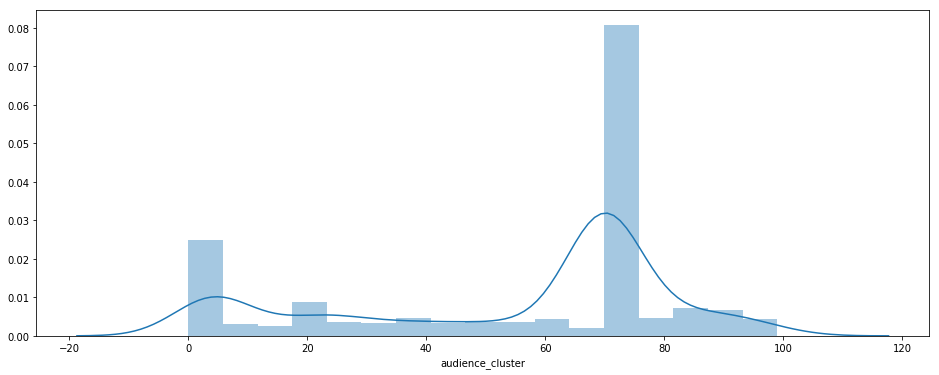

In [14]:
plt.figure(figsize=(16,6))
sns.distplot(df_RT_audience_clean.audience_cluster)
print(df_RT_audience_clean.audience_cluster.value_counts()[0:20])
plt.show()

In [15]:
df_RT_audience_clean[model.labels_ == 47][0:10]

rt_url  \
                                                                                                        
wiki_url                                                                                                
/wiki/Alexander_and_the_Terrible,_Horrible,_No_...  https://www.rottentomatoes.com/m/alexander_and...   
/wiki/Battle_of_the_Sexes_(2017_film)               https://www.rottentomatoes.com/m/battle_of_the...   
/wiki/Beautiful_Boy_(2018_film)                     https://www.rottentomatoes.com/m/beautiful_boy...   
/wiki/Dan_in_Real_Life                              https://www.rottentomatoes.com/m/dan_in_real_life   
/wiki/Dinner_for_Schmucks                           https://www.rottentomatoes.com/m/dinner_for_sc...   
/wiki/Evan_Almighty                                    https://www.rottentomatoes.com/m/evan_almighty   
/wiki/Foxcatcher                                          https://www.rottentomatoes.com/m/foxcatcher   
/wiki/Get_Smart_(film)                                     https://www.rottentomatoes.com/m/get_smart   
/wiki/Last_Flag_Flying                              https://www.rottentomatoes.com/m/last_flag_flying   
/wiki/Little_Miss_Sunshine                          https://www.rottentomatoes.com/m/little_miss_s...   

                                                   audience_score            \
                                                             mean       std   
wiki_url                                                                      
/wiki/Alexander_and_the_Terrible,_Horrible,_No_...       3.673633  1.370235   
/wiki/Battle_of_the_Sexes_(2017_film)                    3.664760  1.339363   
/wiki/Beautiful_Boy_(2018_film)                          3.895238  1.562410   
/wiki/Dan_in_Real_Life                                   3.510070  1.271548   
/wiki/Dinner_for_Schmucks                                2.949597  1.284653   
/wiki/Evan_Almighty                                      2.997996  1.539026   
/wiki/Foxcatcher                                         3.512133  1.192866   
/wiki/Get_Smart_(film)                                   3.595573  1.244493   
/wiki/Last_Flag_Flying                                   3.774336  1.304168   
/wiki/Little_Miss_Sunshine                               4.384848  1.165250   

                                                   audience_cluster  \
                                                                      
wiki_url                                                              
/wiki/Alexander_and_the_Terrible,_Horrible,_No_...               47   
/wiki/Battle_of_the_Sexes_(2017_film)                            47   
/wiki/Beautiful_Boy_(2018_film)                                  47   
/wiki/Dan_in_Real_Life                                           47   
/wiki/Dinner_for_Schmucks                                        47   
/wiki/Evan_Almighty                                              47   
/wiki/Foxcatcher                                                 47   
/wiki/Get_Smart_(film)                                           47   
/wiki/Last_Flag_Flying                                           47   
/wiki/Little_Miss_Sunshine                                       47   

                                                                                        audience_text  
                                                                                                       
wiki_url                                                                                               
/wiki/Alexander_and_the_Terrible,_Horrible,_No_...    Fine if forgettable, family film   A great m...  
/wiki/Battle_of_the_Sexes_(2017_film)                 I don't remember tennis matches being this b...  
/wiki/Beautiful_Boy_(2018_film)                       Rarely does a film move me so much that I'm ...  
/wiki/Dan_in_Real_Life                                I highly recommend this movie...I could watc...  
/wiki/Dinner_for_Schmucks                        

In [16]:
df_RT_audience_clean[model.labels_ == 13][0:10]

rt_url  \
                                                                                    
wiki_url                                                                            
/wiki/Smurfs:_The_Lost_Village  https://www.rottentomatoes.com/m/smurfs_the_lo...   
/wiki/The_Smurfs_(film)               https://www.rottentomatoes.com/m/the_smurfs   
/wiki/The_Smurfs_2                  https://www.rottentomatoes.com/m/the_smurfs_2   

                               audience_score           audience_cluster  \
                                         mean       std                    
wiki_url                                                                   
/wiki/Smurfs:_The_Lost_Village       2.615741  1.955546               13   
/wiki/The_Smurfs_(film)              2.725937  1.528172               13   
/wiki/The_Smurfs_2                   3.096774  1.792661               13   

                                                                    audience_text  
                                                                                   
wiki_url                                                                           
/wiki/Smurfs:_The_Lost_Village    Fun, entertaining, creative and with a nice ...  
/wiki/The_Smurfs_(film)           What a piece of dogshit!   With a great set ...  
/wiki/The_Smurfs_2                Better than the first and very funny. A grea...

In [17]:
# the Disney animated batch
df_RT_audience_clean[model.labels_ == 94][0:10]

rt_url  \
                                                                                  
wiki_url                                                                          
/wiki/Dance_Flick                  https://www.rottentomatoes.com/m/dance_flick   
/wiki/Desert_Dancer              https://www.rottentomatoes.com/m/desert_dancer   
/wiki/Fame_(2009_film)           https://www.rottentomatoes.com/m/10011235-fame   
/wiki/Feel_the_Noise            https://www.rottentomatoes.com/m/feel_the_noise   
/wiki/Footloose_(2011_film)     https://www.rottentomatoes.com/m/footloose-2010   
/wiki/How_She_Move                https://www.rottentomatoes.com/m/how_she_move   
/wiki/Step_Up_2:_The_Streets  https://www.rottentomatoes.com/m/step_up_2_the...   
/wiki/Step_Up_Revolution      https://www.rottentomatoes.com/m/step_up_revol...   
/wiki/Take_the_Lead              https://www.rottentomatoes.com/m/take_the_lead   

                             audience_score           audience_cluster  \
                                       mean       std                    
wiki_url                                                                 
/wiki/Dance_Flick                  2.053320  1.551296               94   
/wiki/Desert_Dancer                4.000000  1.575272               94   
/wiki/Fame_(2009_film)             2.548241  1.347807               94   
/wiki/Feel_the_Noise               1.695565  1.665238               94   
/wiki/Footloose_(2011_film)        3.315338  1.563216               94   
/wiki/How_She_Move                 2.666835  1.703020               94   
/wiki/Step_Up_2:_The_Streets       3.402020  1.681246               94   
/wiki/Step_Up_Revolution           3.474722  1.678142               94   
/wiki/Take_the_Lead                3.694332  1.517439               94   

                                                                  audience_text  
                                                                                 
wiki_url                                                                         
/wiki/Dance_Flick               the funniest movie ever   Spoof is usually e...  
/wiki/Desert_Dancer             If you can overlook a screenplay that seems ...  
/wiki/Fame_(2009_film)          won't be as good as original, that got an os...  
/wiki/Feel_the_Noise            Generic and boring, yet somehow still entert...  
/wiki/Footloose_(2011_film)     Horrible cast and even worst acting. Some mo...  
/wiki/How_She_Move              this is da best soo far!!!! luv it luv it lu...  
/wiki/Step_Up_2:_The_Streets    It has great dance sequences. Other than the...  
/wiki/Step_Up_Revolution        I love all of or movies   I would rather a g...  
/wiki/Take_the_Lead             Take the lead isn't so much a motion picture...

In [18]:
# find the closest points to the cluster centers for each cluster, then return audience_text
def find_cluster_point():
    cluster = []
    for x in range(10):
        closest_point = int(np.argmin(np.power(X_tfidf - model.cluster_centers_[x],2).sum(axis=1), axis=0))
        cluster.append((x,closest_point))
    return cluster

def return_text(df):
    for x, y in find_cluster_point():
        print(x, y, df.rt_url.values[y])

In [19]:
# only works for KMeans, not SpectralClustering method
# return_text(df_RT_audience_clean)

In [20]:
# a way to look at the audience_text of each of the closest point to the cluster centers 
df_RT_audience_clean.audience_text[729][:2000]

'  I really did enjoy this movie, as it was quite entertaining and full of action, although the editing was bad, this movie has something about it that makes me want to watch it over and over!   i think Gamer is a good movie. i think Gerard Butler, Michael C. Hall and Logan Lerman are all good actors. Michael C. Hall is why i saw the movie Gamer and i\'m happy i did. Gamer is a good movie.   I don\'t understand the bad reviews, I am no expert but I have seen way worst movies than this one. The only thing that could have been better was the ending, but oh well, I still liked it a lot!   This movie was better than expected, of course my expectations couldnt have been any lower. This movie is mostly action with a hint of a story line. and the transisions between each scene could have been better, but in all the movie wasnt too bad. Another element that I found out of place was Gerard Butler. I believe he\'s a great actor, but I dont think this was his film. This Dude Film is not one of th

The third cluster seems to be the horror and suspense cluster. Ouija is the film closest to the center of the cluster, but it also includes Annabelle franchises, A Quiet Place, Nightmare on Elm Street, etc. There are some suspense films like Apollo 18 mixed in as well. 4 is the animated, Disney or family cluster. 5 and 6 are action clusters, but I'm not sure what differentiates them. 9 seems to be niche films that while they make sense together, I can't really understand what brings them together. Could be character driven, but that's anybody's guess

In [21]:
# explore whether the clusters correspond to something related to the scores
# could be too many clusters in Kmeans
# does the model perform any better 
# look at center of cluster to determine text indicative of the cluster

In [22]:
# determine the right number of clusters with silhouette plots
def silhouette_scores(X, range_n_clusters, model_type):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
    #     ax1.set_ylim([0, len(X_tfidf) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = model_type(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(X)

        #bring in my own model and values instead of X_tfidf for X and predicted cluster values for cluster_labels

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

I noticed that the silhouette scores were increasing from 10 to 15 clusters. So on the set below I'm going to look at 10-100 in increments of 5 to find the right range, then I will dive deeper when I have a relevant range.

For n_clusters = 5 The average silhouette_score is : 0.007330369286057269
For n_clusters = 10 The average silhouette_score is : 0.0118994116858561
For n_clusters = 15 The average silhouette_score is : 0.015728355525434813
For n_clusters = 20 The average silhouette_score is : 0.01663576950674451
For n_clusters = 25 The average silhouette_score is : 0.020243015681694627
For n_clusters = 30 The average silhouette_score is : 0.02353120143813959
For n_clusters = 35 The average silhouette_score is : 0.0253231650526927
For n_clusters = 40 The average silhouette_score is : 0.029251197668854333
For n_clusters = 45 The average silhouette_score is : 0.03160301650049836
For n_clusters = 50 The average silhouette_score is : 0.03455866188233097
For n_clusters = 55 The average silhouette_score is : 0.03600394002035959
For n_clusters = 60 The average silhouette_score is : 0.03869683459008392
For n_clusters = 65 The average silhouette_score is : 0.04277073359660747
For n_clusters = 70 The average silho

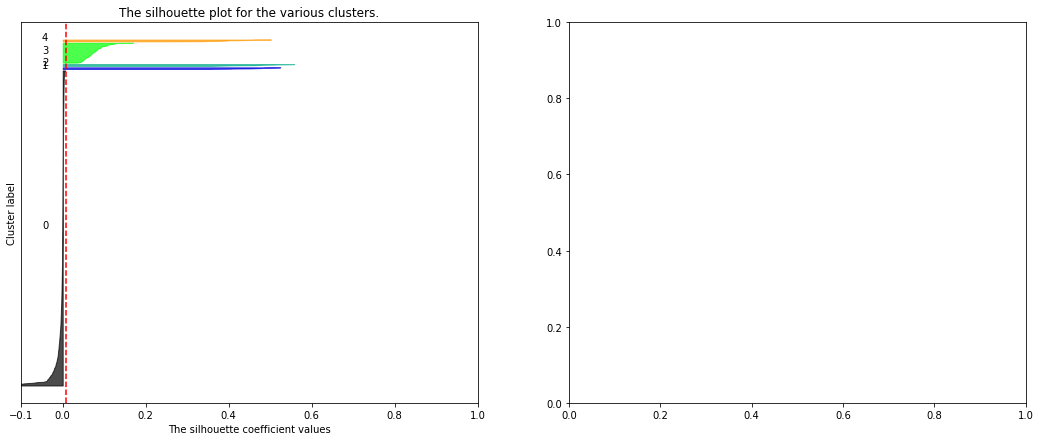

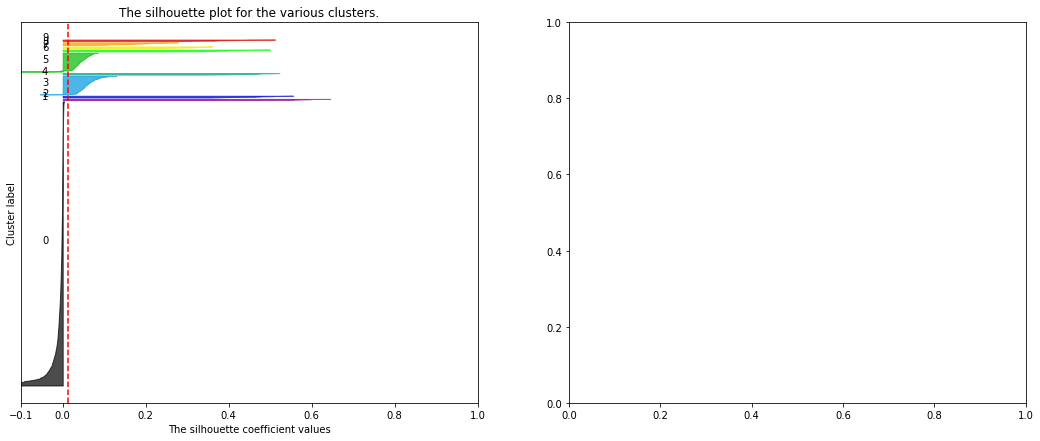

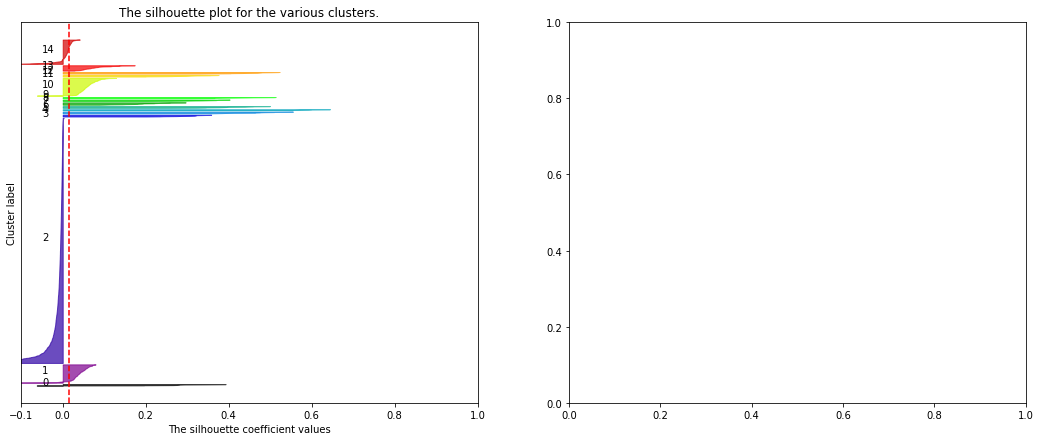

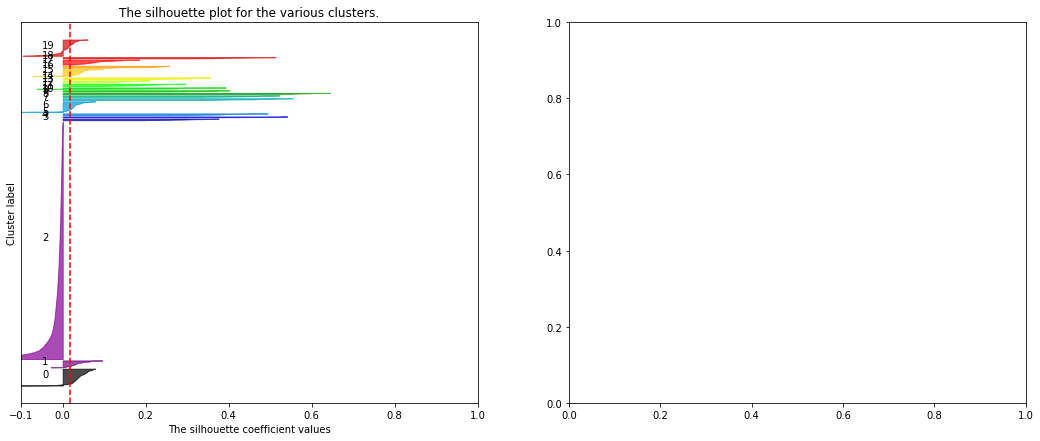

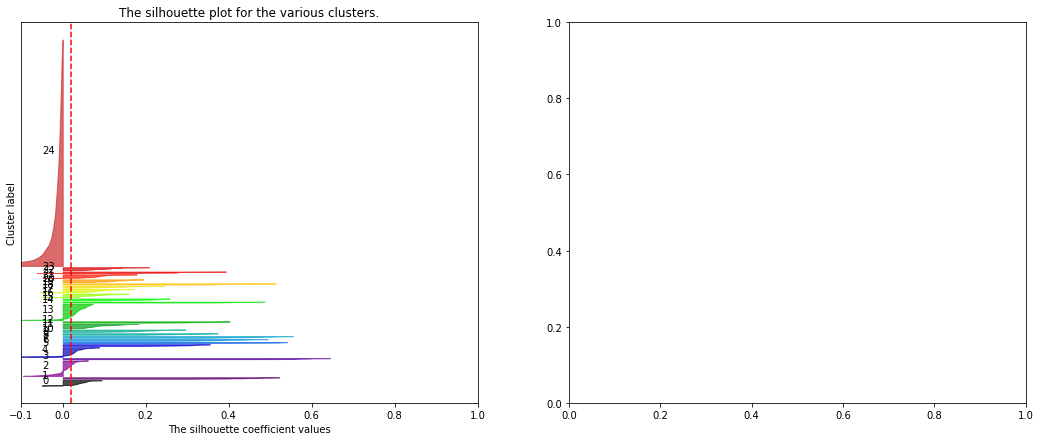

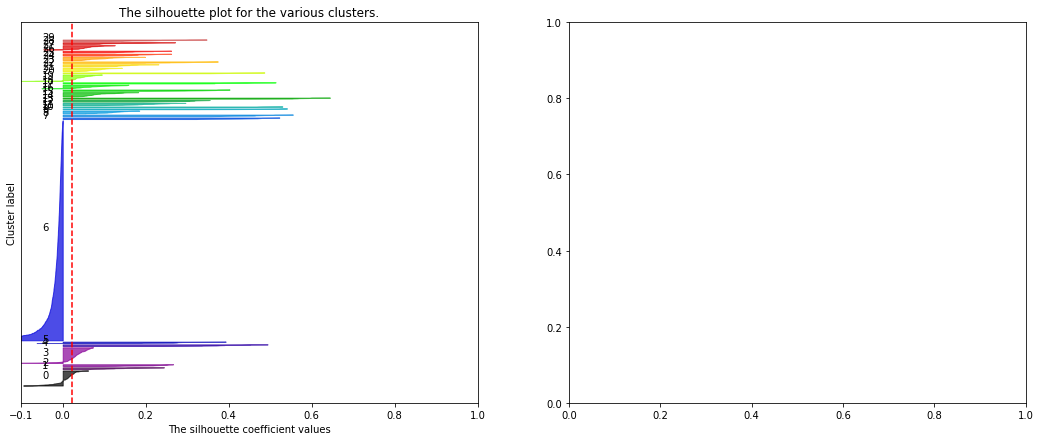

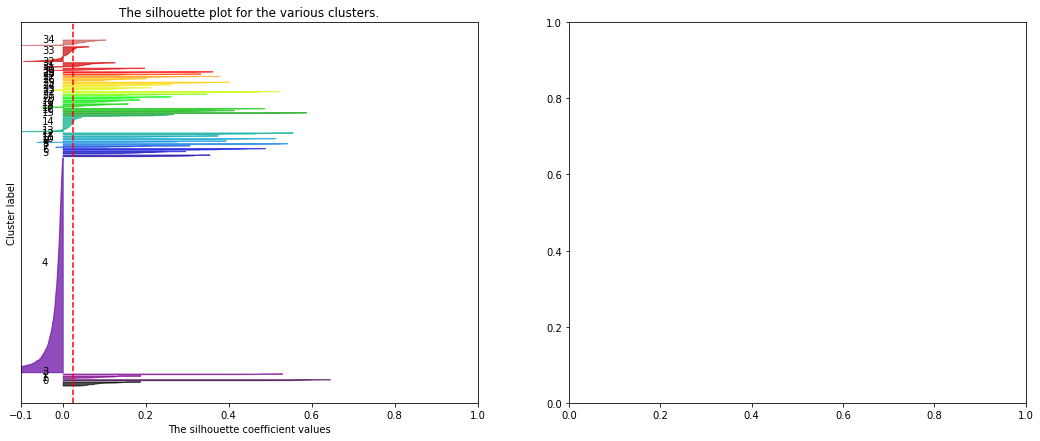

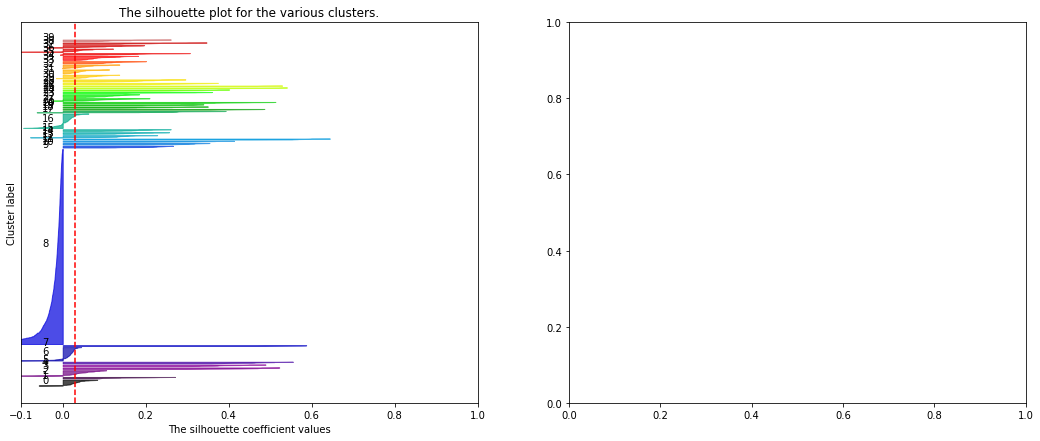

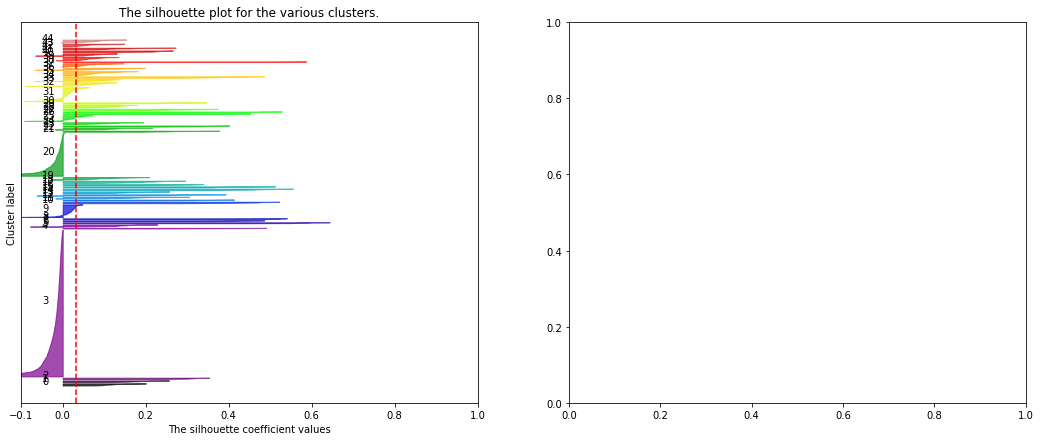

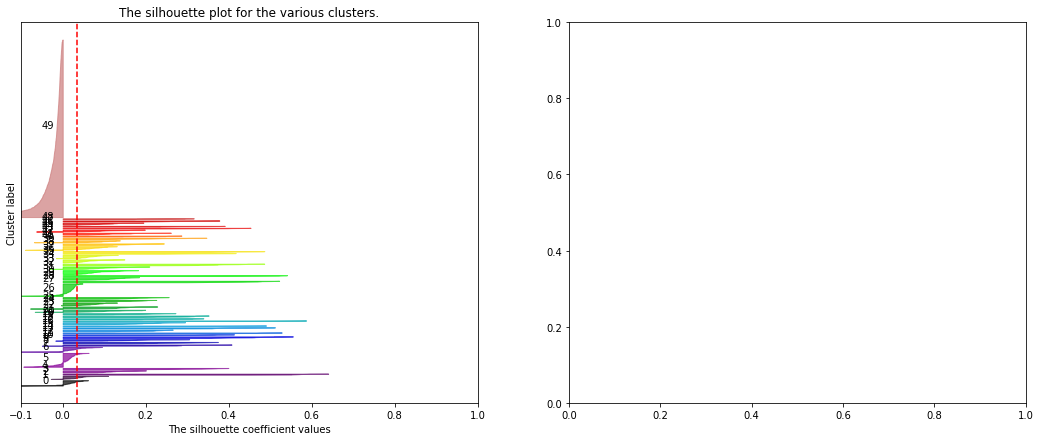

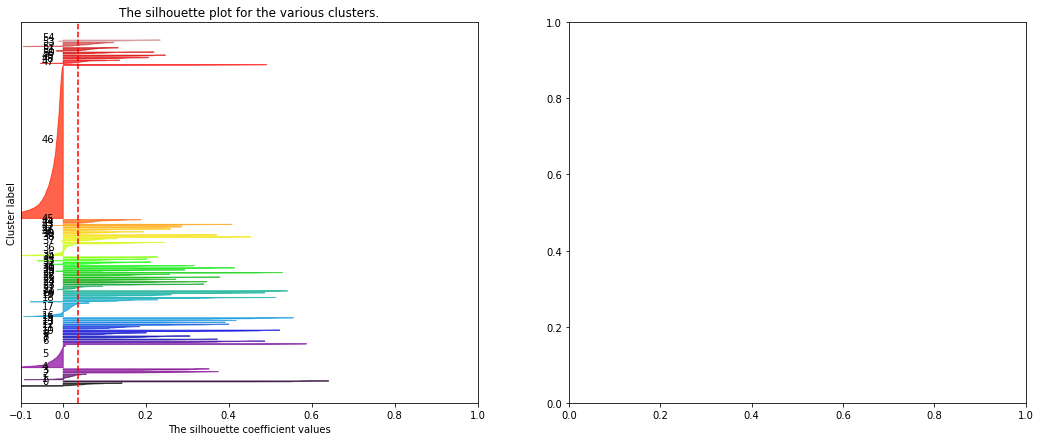

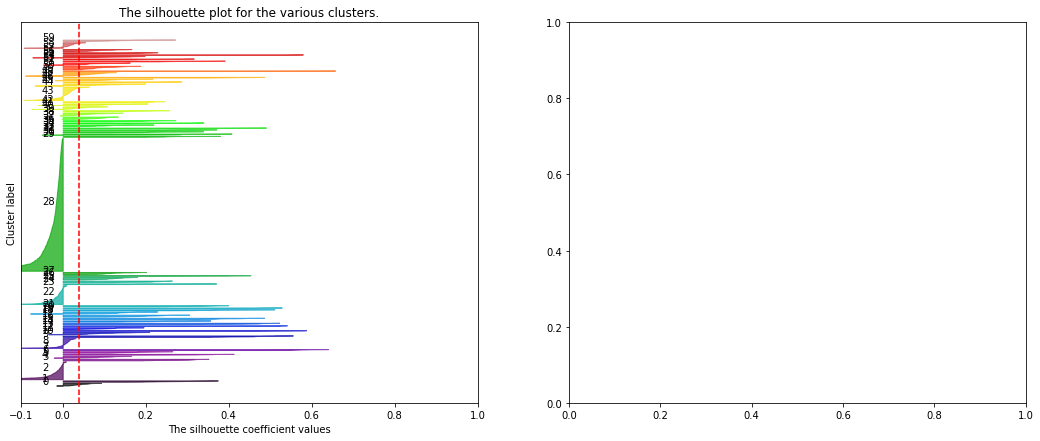

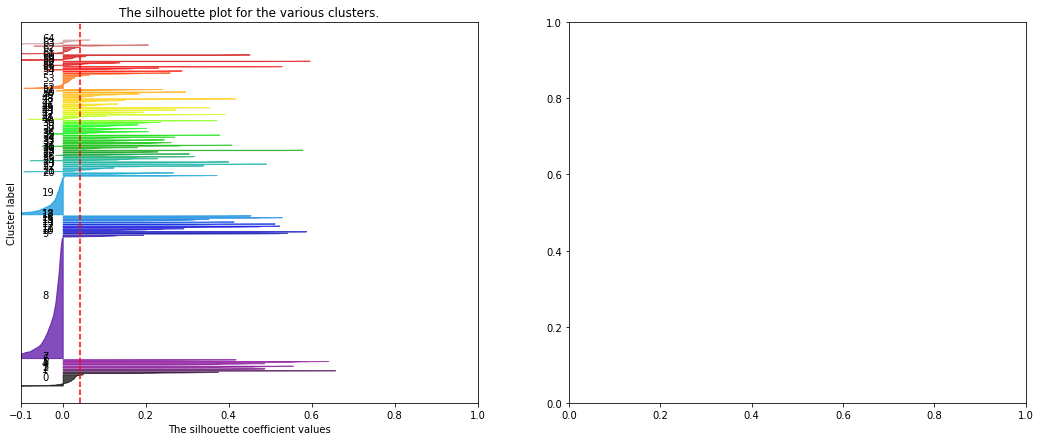

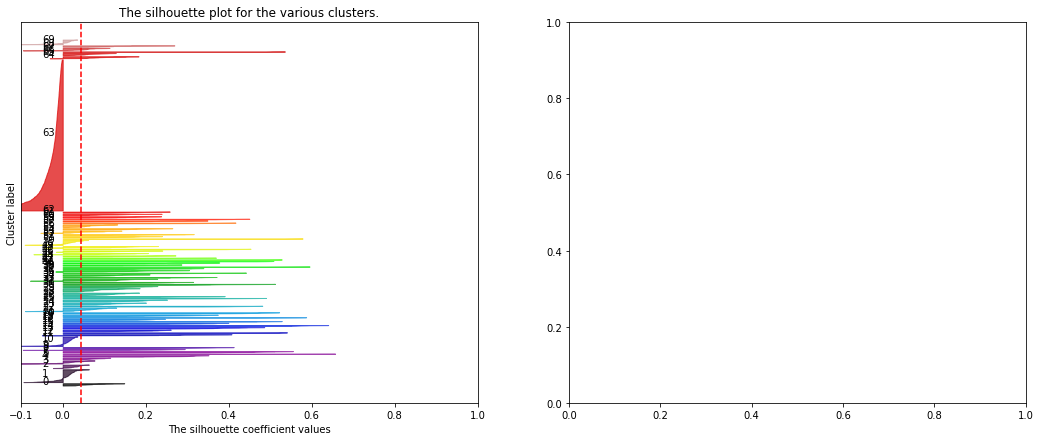

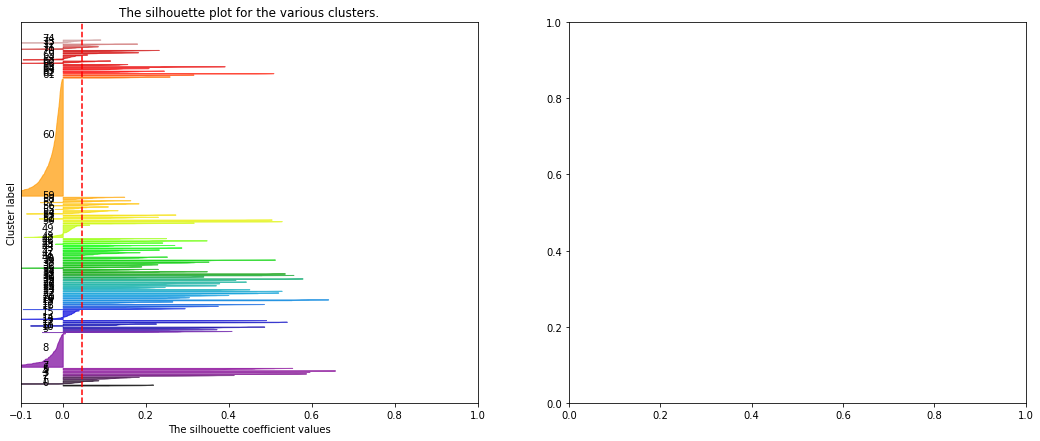

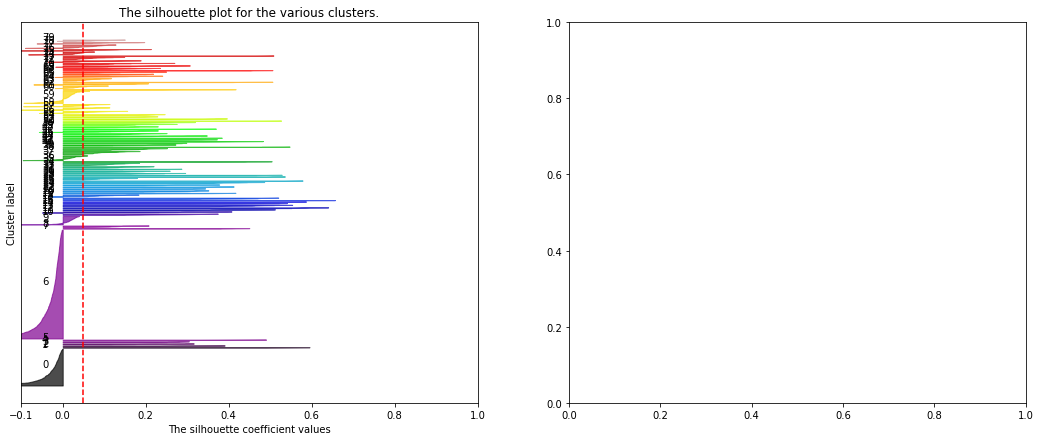

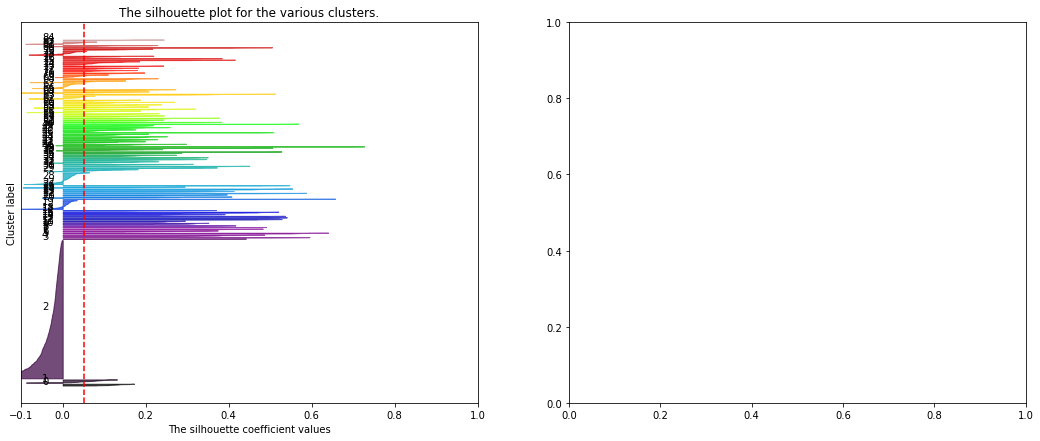

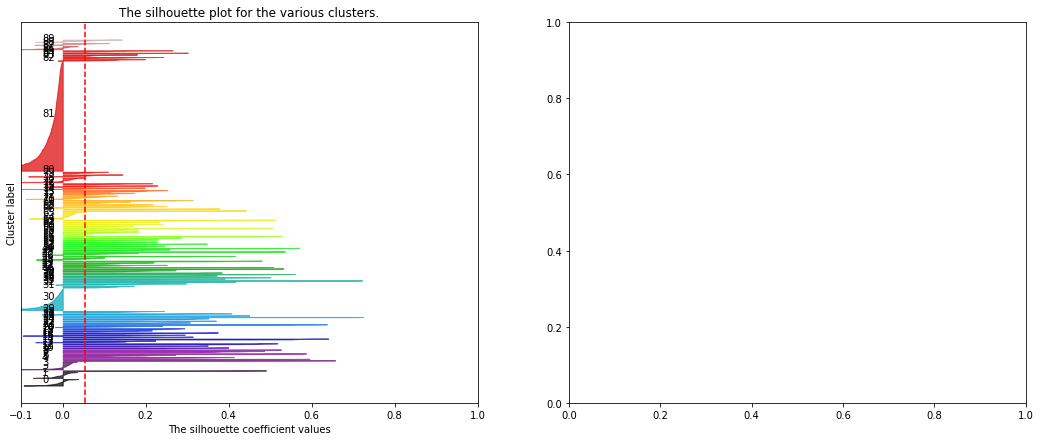

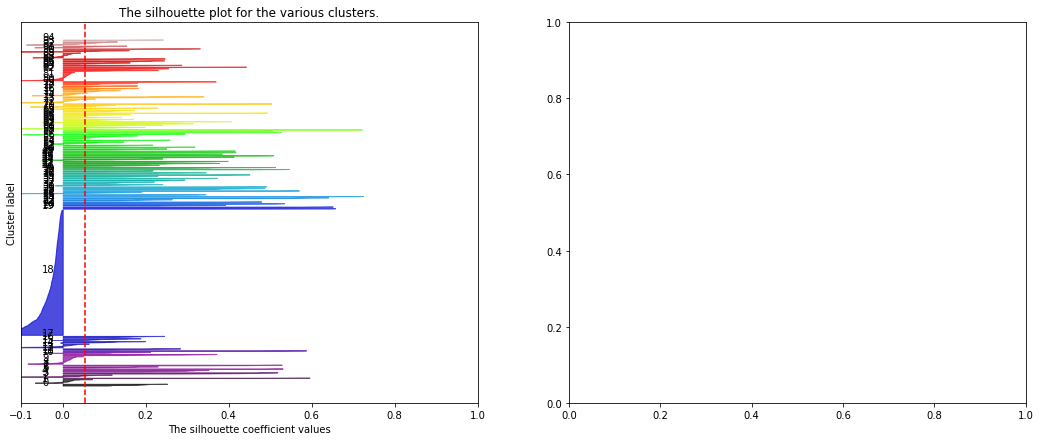

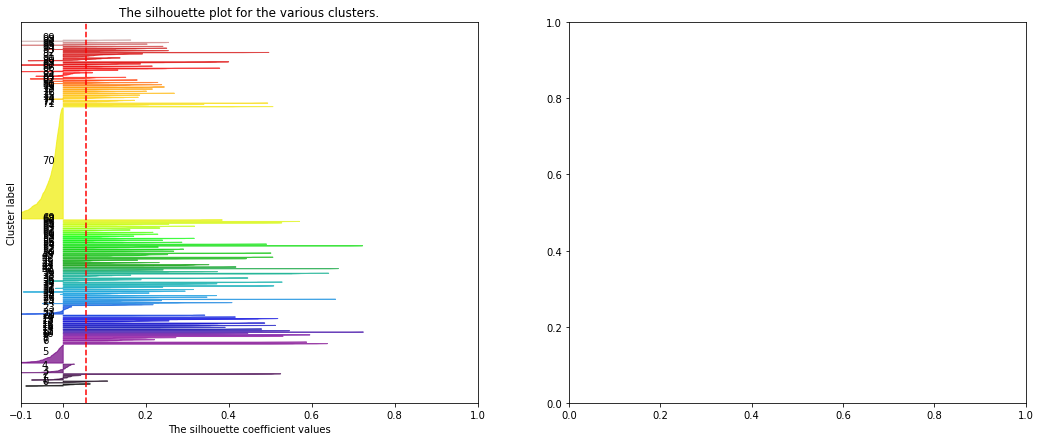

In [23]:
range_n_clusters = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

silhouette_scores(X_tfidf, range_n_clusters, SpectralClustering)

In [24]:
# SpectralClustering at 100 clusters is 0.04548
# Kmeans at 100 clusters is 0.03047
# AgglomerativeClustering at 100 clusters is 0.03833

# SpectralClustering at 100 clusters is 0.0639 with increased number of reviews to 500 from 50
# SpectralClustering at 100 clusters is 0.0655 with increased number of reviews to all reviews (~1000)

### Clustering based on bomojo information

In [25]:
df_bomojo_clean.describe()

,bomojo_dom_boxoffice,bomojo_ww_boxoffice,bomojo_opwkd_dom_boxoffice,bomojo_numtheatres
count,2.072000e+03,2.072000e+03,2.072000e+03,2072.000000
mean,5.479287e+07,1.294692e+08,1.733963e+07,2269.088320
std,7.645794e+07,2.029696e+08,2.401420e+07,1320.264747
min,7.420000e+02,8.370000e+02,1.620000e+02,1.000000
25%,6.879476e+06,1.432473e+07,2.305919e+06,1132.750000
50%,3.101388e+07,5.471482e+07,1.048757e+07,2679.500000
75%,6.925649e+07,1.504751e+08,2.210445e+07,3232.250000
max,9.366622e+08,2.068224e+09,2.576982e+08,4485.000000


In [26]:
df_bomojo_clean.columns

Index(['bomojo_url', 'bomojo_title', 'bomojo_genre', 'bomojo_dom_releasedate',
       'bomojo_mpaa_rating', 'bomojo_distributor', 'bomojo_dom_boxoffice',
       'bomojo_ww_boxoffice', 'bomojo_opwkd_dom_boxoffice',
       'bomojo_numtheatres', 'month'],
      dtype='object')

In [27]:
bomojo_cluster = df_bomojo_clean[['bomojo_genre', 'bomojo_mpaa_rating','bomojo_distributor','month', 'bomojo_numtheatres']]
bomojo_cluster = pd.get_dummies(bomojo_cluster)

For n_clusters = 2 The average silhouette_score is : 0.7270159635071436
For n_clusters = 3 The average silhouette_score is : 0.6092572729814109
For n_clusters = 4 The average silhouette_score is : 0.6119951827286126
For n_clusters = 5 The average silhouette_score is : 0.6081225881310879
For n_clusters = 6 The average silhouette_score is : 0.5922914103277598
For n_clusters = 7 The average silhouette_score is : 0.5970257024262186
For n_clusters = 8 The average silhouette_score is : 0.5823504359364927
For n_clusters = 9 The average silhouette_score is : 0.5692156699621541
For n_clusters = 10 The average silhouette_score is : 0.5774707914559863
For n_clusters = 11 The average silhouette_score is : 0.581860038880532
For n_clusters = 12 The average silhouette_score is : 0.5783716875148162
For n_clusters = 13 The average silhouette_score is : 0.566956112359705
For n_clusters = 14 The average silhouette_score is : 0.5719763789998891
For n_clusters = 15 The average silhouette_score is : 0.57133

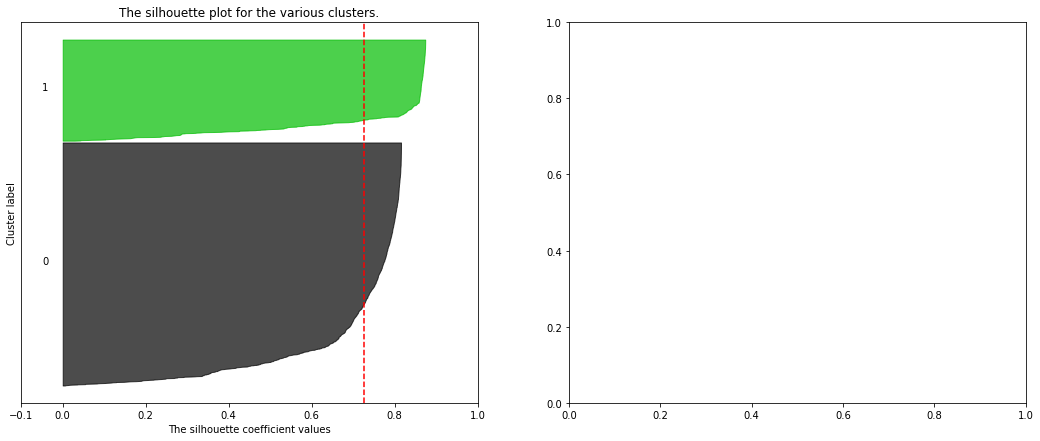

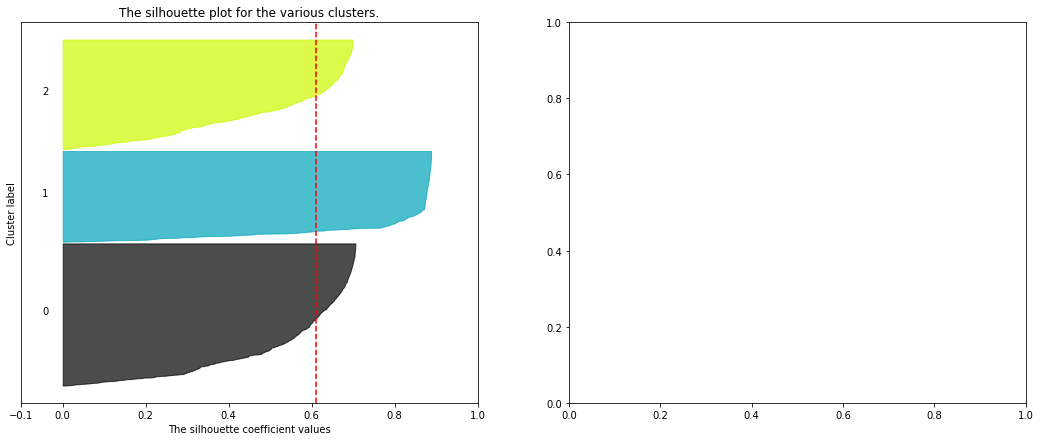

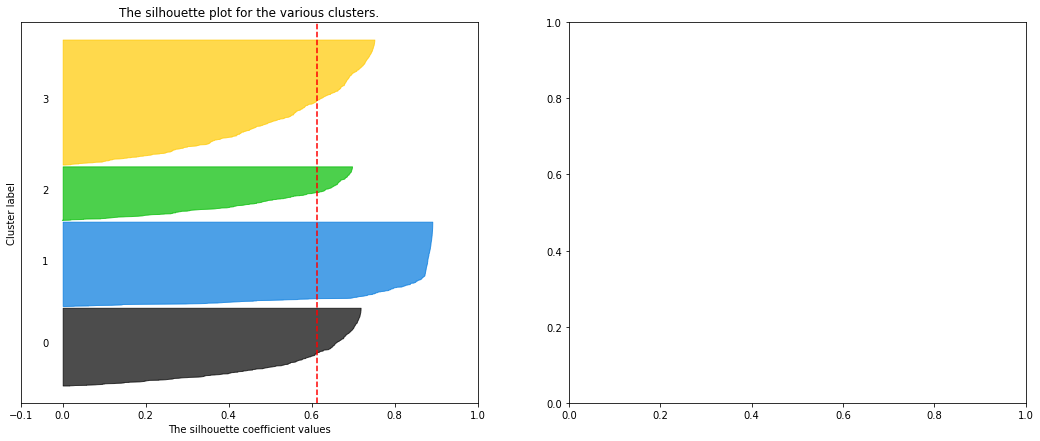

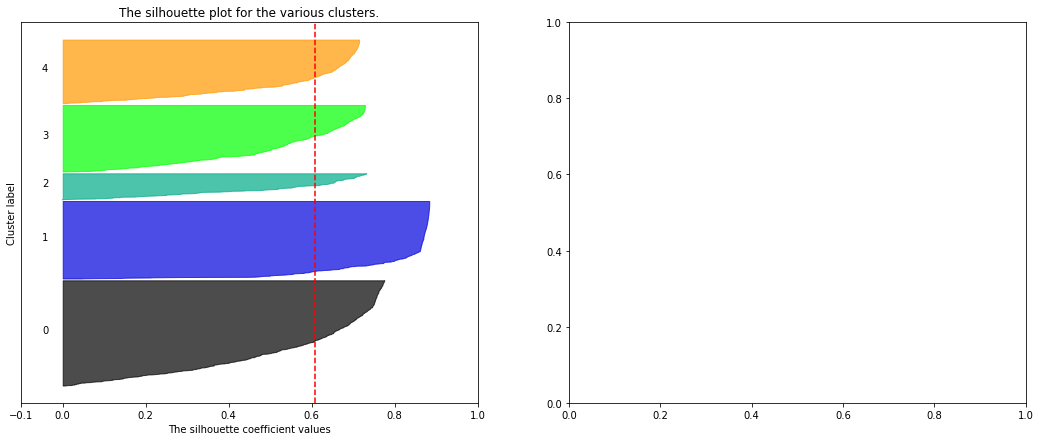

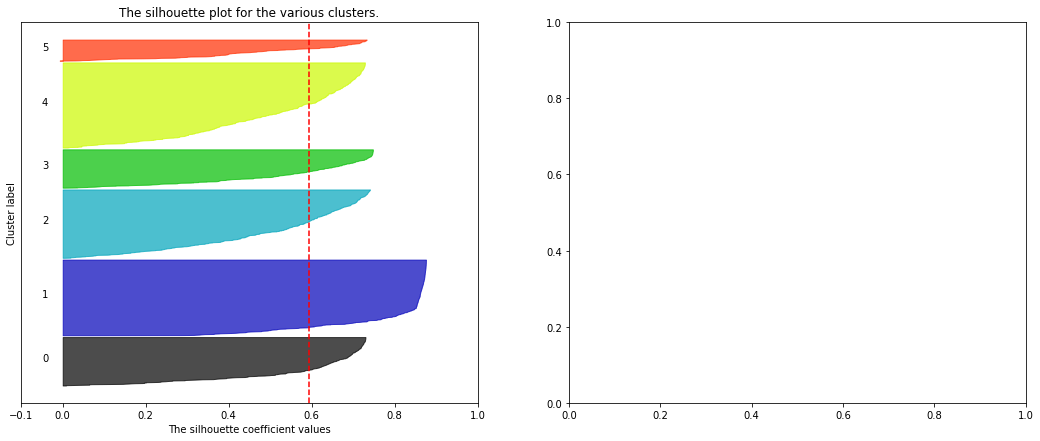

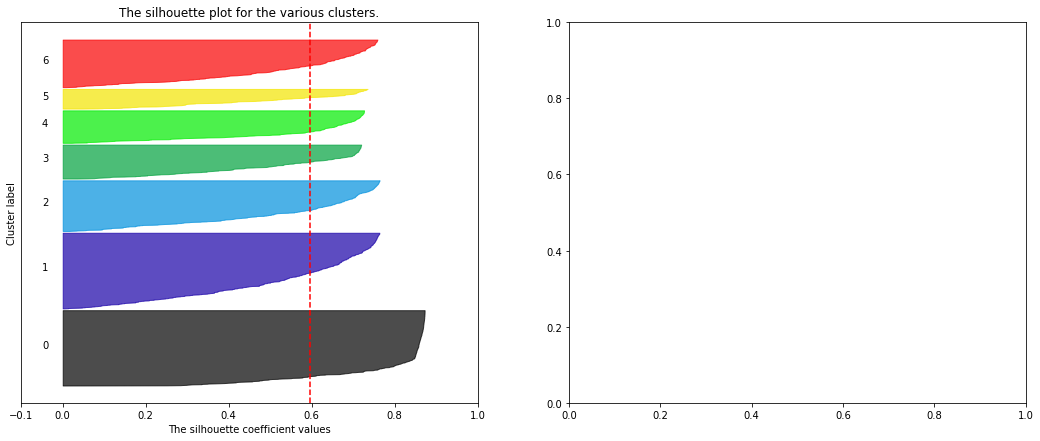

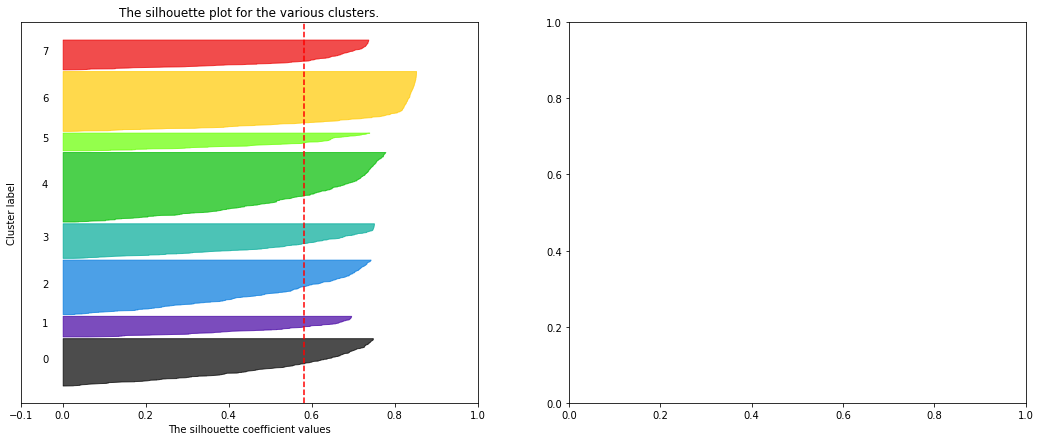

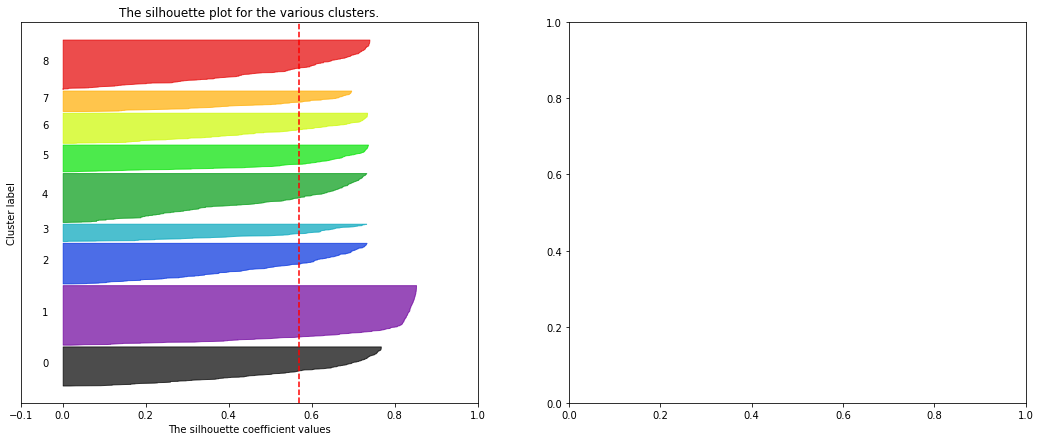

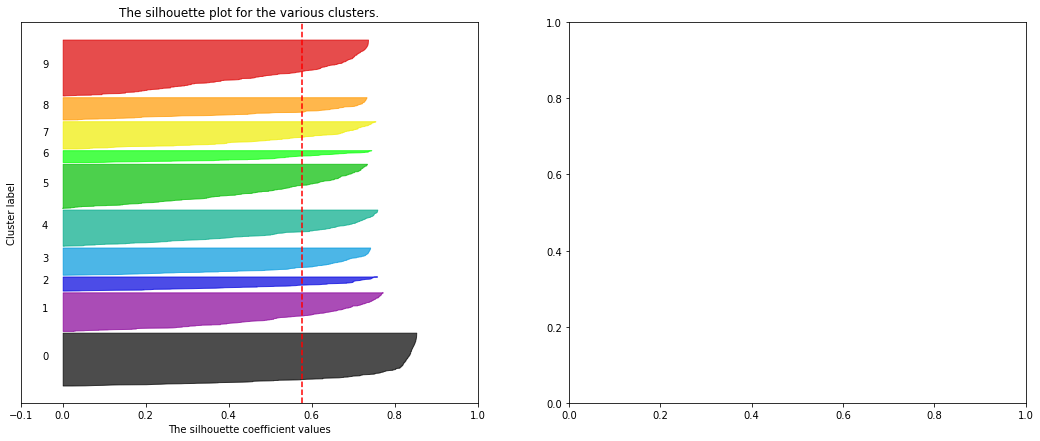

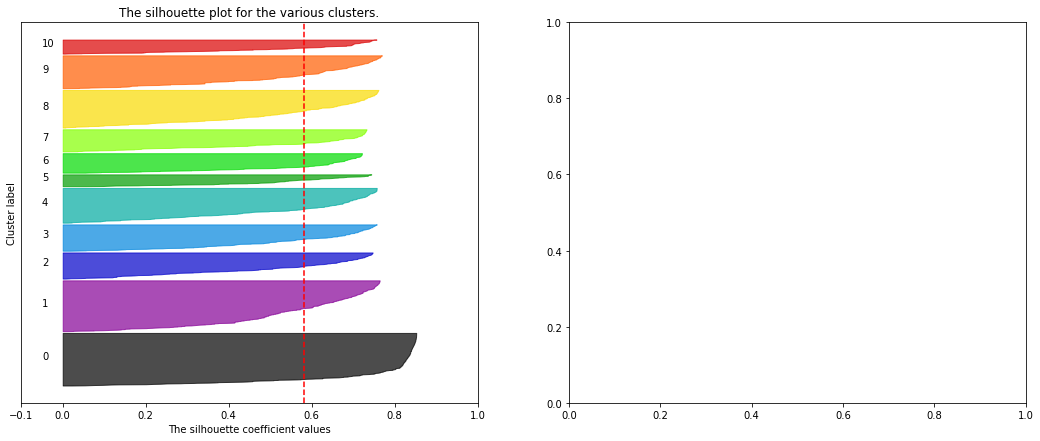

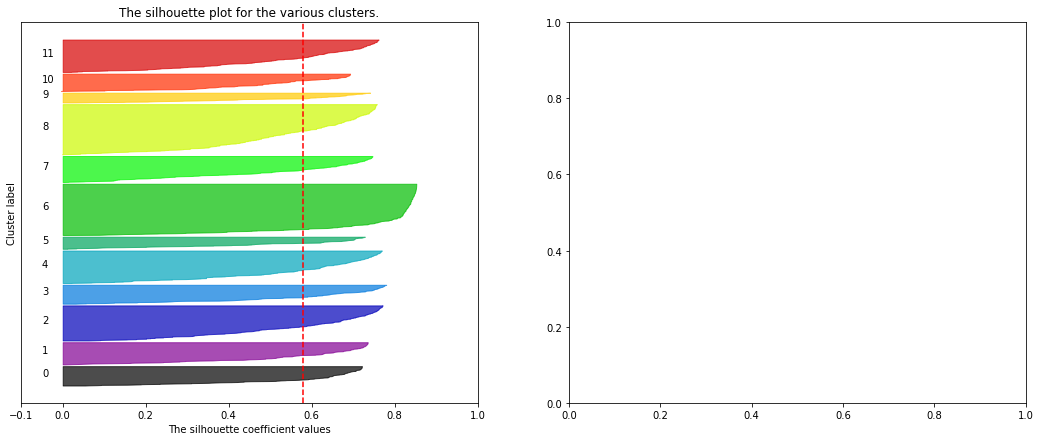

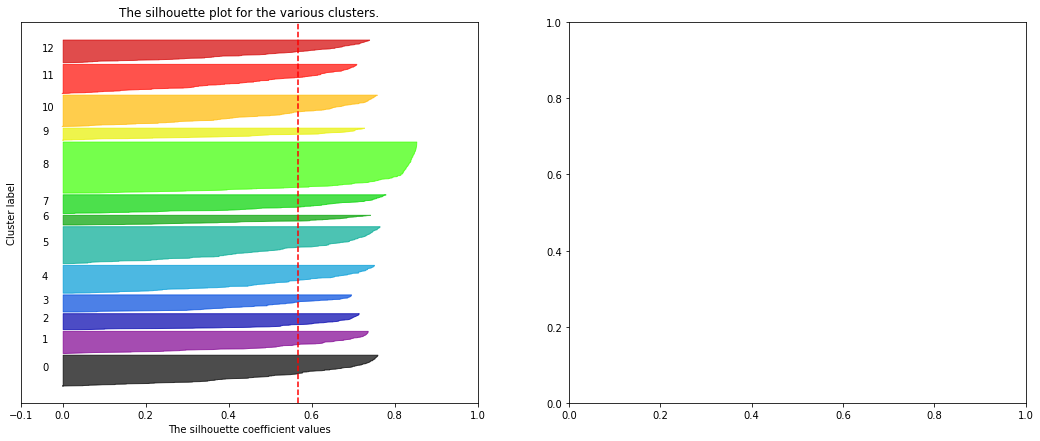

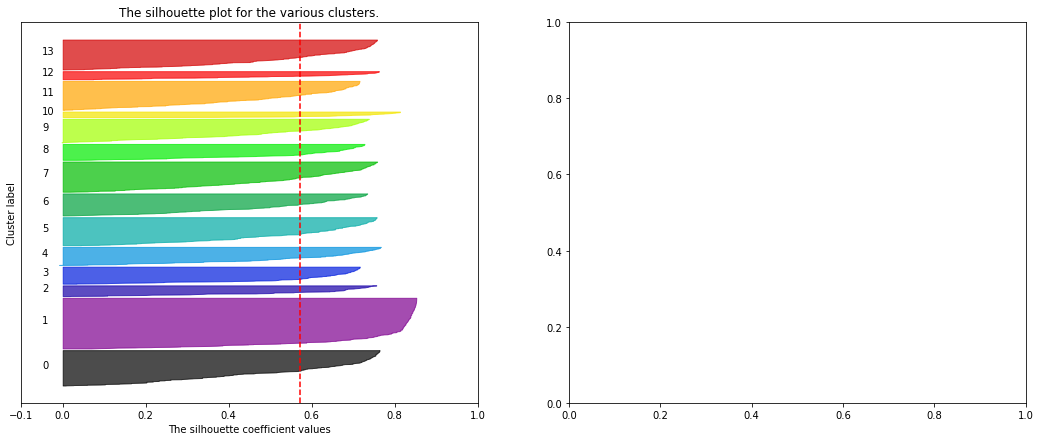

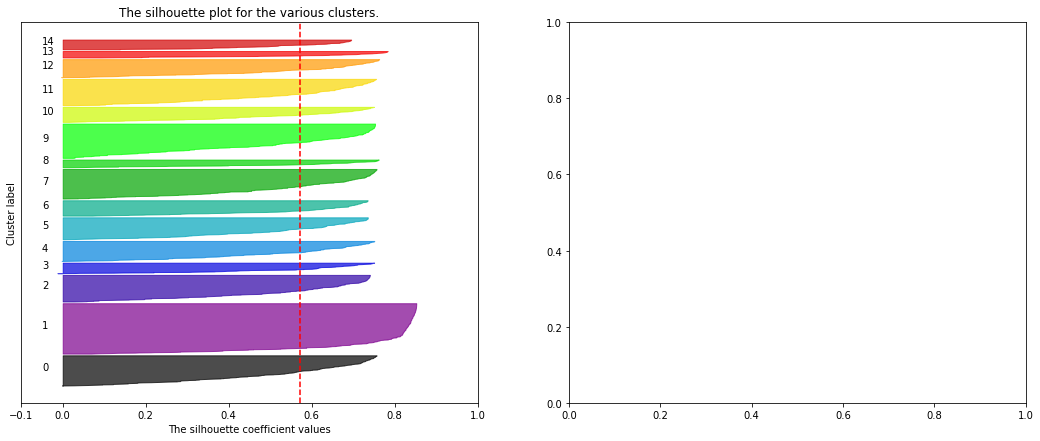

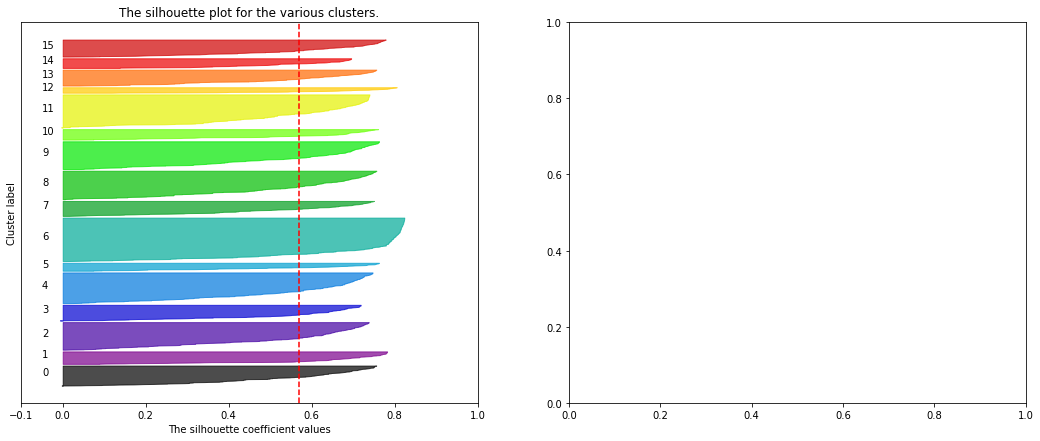

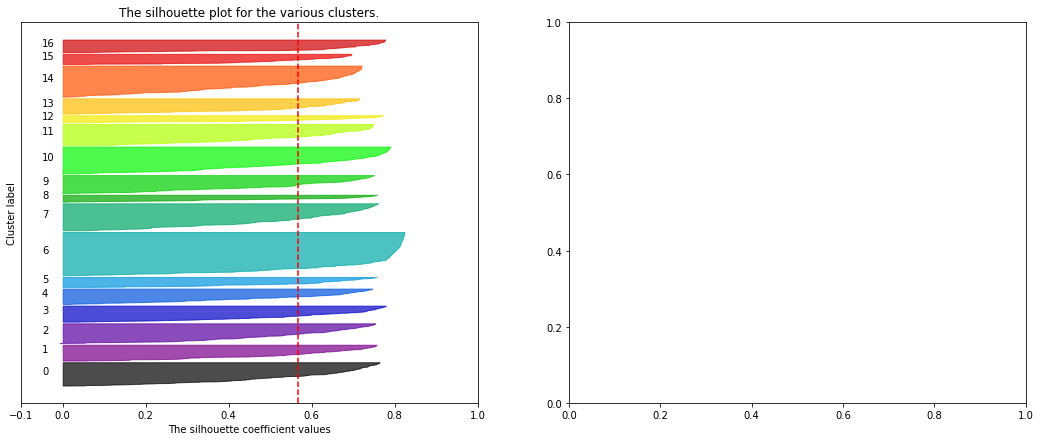

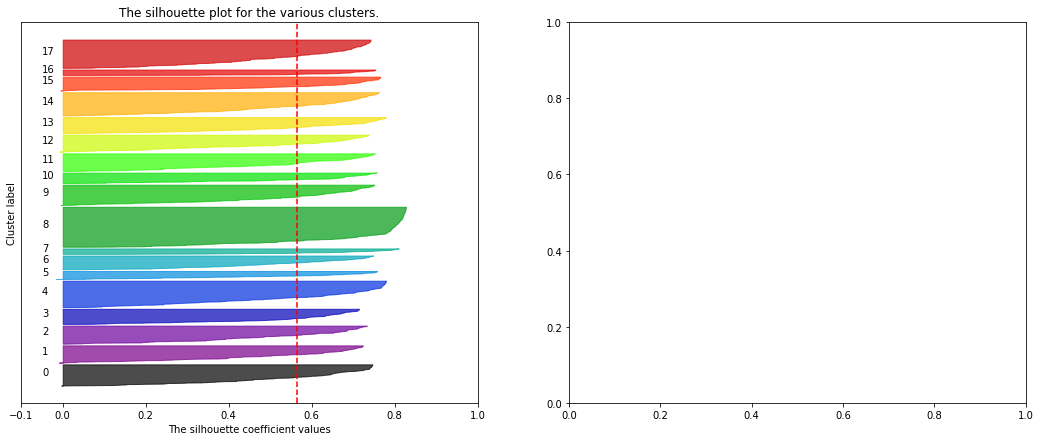

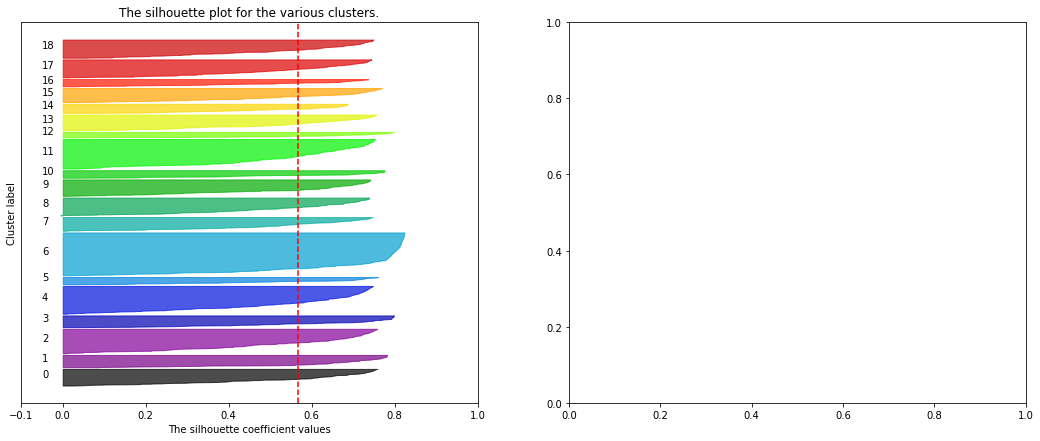

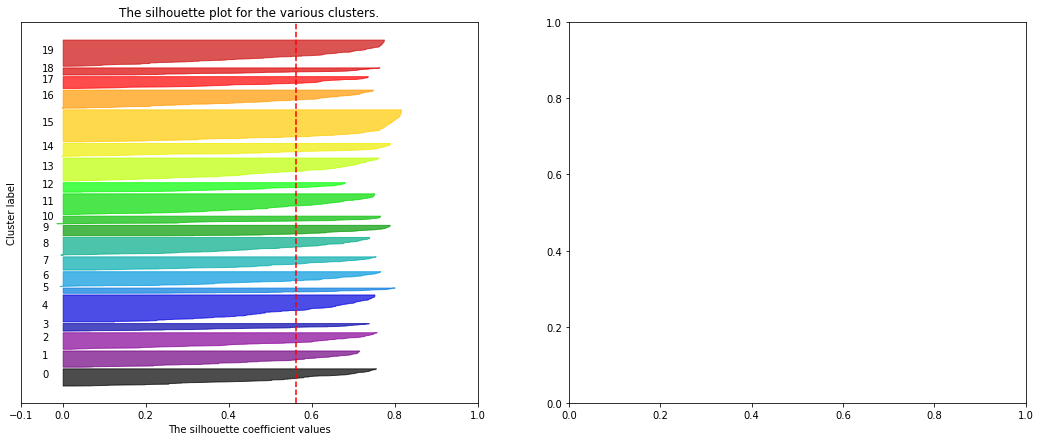

In [28]:
# use silhouette plots for number of cluster identification
# print out a bunch of samples where cluster == 2 (whatever) and identify similarities among points
range_n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

silhouette_scores(bomojo_cluster, range_n_clusters, KMeans)

In [29]:
# KMeans 4 clusters silhouette score of 0.6403 (not as good as 2 clusters but want more separation)

Much better silhouette scores for entire cluster range when adding in number of theaters in wide release. 

In [30]:
df_bomojo_clean['bomojo_cluster'] =  KMeans(n_clusters=6, random_state=42).fit_predict(bomojo_cluster)

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


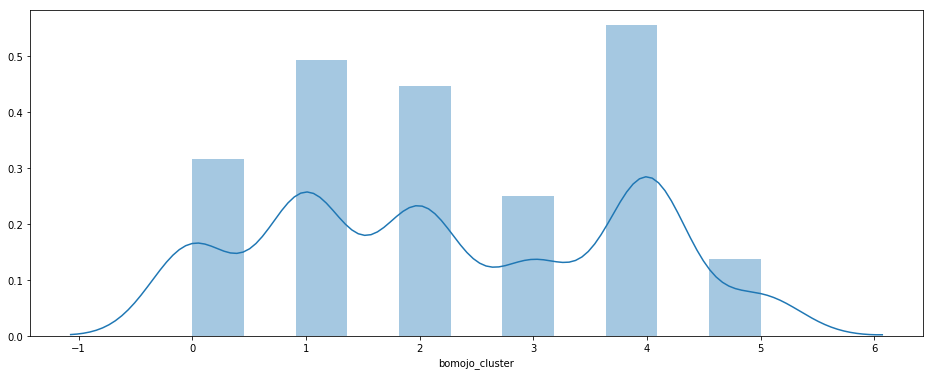

In [31]:
plt.figure(figsize=(16,6))
sns.distplot(df_bomojo_clean['bomojo_cluster'])
plt.show()

### Merging datatables together before LR

In [32]:
def join_dataframes(df1, *others):
    df_bo_predictor = df1
    for df in others:
        df_bo_predictor = df_bo_predictor.merge(df, left_index=True, right_index=True)
    
    df_bo_predictor.to_csv('df_bo_predictor.csv',sep=',',index=False)

In [33]:
dfs_to_join = [df_bomojo_clean, df_RT_critic_clean,
               df_metacritic_clean, df_RT_audience_clean]
join_dataframes(df_wiki_info, *dfs_to_join)

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [34]:
df_bo_predictor = pd.read_csv('df_bo_predictor.csv')
df_bo_predictor = df_bo_predictor.dropna()

In [35]:
df_bo_predictor.head()

,bomojo_link,rottentomatoes_link,metacritic_link,imdb_link,bomojo_url,bomojo_title,bomojo_genre,bomojo_dom_releasedate,bomojo_mpaa_rating,bomojo_distributor,...,month,bomojo_cluster,rt_review_fresh,rt_review_rotten,mc_score,"('rt_url', '')","('audience_score', 'mean')","('audience_score', 'std')","('audience_cluster', '')","('audience_text', '')"
0,http://www.boxofficemojo.com/movies/?id=johnwi...,https://www.rottentomatoes.com/m/john_wick_cha...,http://www.metacritic.com/movie/john-wick-chap...,https://www.imdb.com/title/tt4425200/,http://www.boxofficemojo.com/movies/?id=johnwi...,John Wick,Action,2014-10-24,R,Lionsgate/Summit,...,October,2,0.809524,0.190476,75.000000,https://www.rottentomatoes.com/m/john_wick_cha...,4.034274,1.357728,31,Melhor filme que j� 1/2 1/2 vi This starte...
1,https://www.boxofficemojo.com/movies/?id=close...,https://www.rottentomatoes.com/m/closed_circui...,http://www.metacritic.com/movie/closed-circuit,https://www.imdb.com/title/tt2218003/,https://www.boxofficemojo.com/movies/?id=close...,Closed Circuit,Thriller,2013-08-28,R,Focus Features,...,August,5,0.424242,0.575758,54.051282,https://www.rottentomatoes.com/m/closed_circui...,2.962963,1.130160,70,A really good British suspense thriller. Ame...
2,https://www.boxofficemojo.com/movies/?id=sexan...,https://www.rottentomatoes.com/m/3_d_sex_and_z...,http://www.metacritic.com/movie/3-d-sex-and-ze...,https://www.imdb.com/title/tt1365048/,https://www.boxofficemojo.com/movies/?id=sexan...,Sex and Zen 3D:Extreme Ecstasy,Foreign,2011-08-12,Unrated,China Lion,...,August,1,0.285714,0.714286,44.000000,https://www.rottentomatoes.com/m/3_d_sex_and_z...,2.109756,1.339366,70,most misleading and sadistic film ever made....
3,https://www.boxofficemojo.com/movies/?id=dolph...,https://www.rottentomatoes.com/m/dolphin_tale,http://www.metacritic.com/movie/dolphin-tale,https://www.imdb.com/title/tt1564349/,https://www.boxofficemojo.com/movies/?id=dolph...,Dolphin Tale,Family,2011-09-23,PG,Warner Bros.,...,September,4,0.833333,0.166667,66.806452,https://www.rottentomatoes.com/m/dolphin_tale,4.157868,1.424132,70,Decent family movie will entertain kids. I...
4,http://www.boxofficemojo.com/movies/?id=walkto...,https://www.rottentomatoes.com/m/a_walk_among_...,http://www.metacritic.com/movie/a-walk-among-t...,https://www.imdb.com/title/tt0365907/,http://www.boxofficemojo.com/movies/?id=walkto...,A Walk Among the Tombstones,Drama,2014-09-19,R,Universal,...,September,2,0.583333,0.416667,61.000000,https://www.rottentomatoes.com/m/a_walk_among_...,3.438259,1.056285,40,I enjoyed it. Even the storyline with TJ was...


In [36]:
df_bo_predictor.columns

Index(['bomojo_link', 'rottentomatoes_link', 'metacritic_link', 'imdb_link',
       'bomojo_url', 'bomojo_title', 'bomojo_genre', 'bomojo_dom_releasedate',
       'bomojo_mpaa_rating', 'bomojo_distributor', 'bomojo_dom_boxoffice',
       'bomojo_ww_boxoffice', 'bomojo_opwkd_dom_boxoffice',
       'bomojo_numtheatres', 'month', 'bomojo_cluster', 'rt_review_fresh',
       'rt_review_rotten', 'mc_score', '('rt_url', '')',
       '('audience_score', 'mean')', '('audience_score', 'std')',
       '('audience_cluster', '')', '('audience_text', '')'],
      dtype='object')

In [37]:
df_bo_predictor.describe()

,bomojo_dom_boxoffice,bomojo_ww_boxoffice,bomojo_opwkd_dom_boxoffice,bomojo_numtheatres,bomojo_cluster,rt_review_fresh,rt_review_rotten,mc_score,"('audience_score', 'mean')","('audience_score', 'std')","('audience_cluster', '')"
count,1.121000e+03,1.121000e+03,1.121000e+03,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000
mean,5.667921e+07,1.418539e+08,1.810784e+07,2326.217663,2.162355,0.499085,0.500915,57.203967,3.430908,1.410281,53.135593
std,7.725780e+07,2.180923e+08,2.558724e+07,1365.369354,1.554501,0.286578,0.286578,15.039681,0.587823,0.233634,29.297053
min,7.420000e+02,8.370000e+02,1.620000e+02,1.000000,0.000000,0.000000,0.000000,18.000000,1.483213,0.801934,0.000000
25%,5.802208e+06,1.310227e+07,1.673351e+06,862.000000,1.000000,0.243243,0.250000,45.947368,3.046763,1.241235,23.000000
50%,3.115346e+07,6.005214e+07,1.080915e+07,2815.000000,2.000000,0.500000,0.500000,56.833333,3.472644,1.372105,70.000000
75%,7.211066e+07,1.678856e+08,2.251836e+07,3353.000000,4.000000,0.750000,0.756757,67.965517,3.852507,1.561931,70.000000
max,6.788155e+08,2.048360e+09,2.576982e+08,4485.000000,5.000000,1.000000,1.000000,100.000000,4.771357,2.284514,99.000000


c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


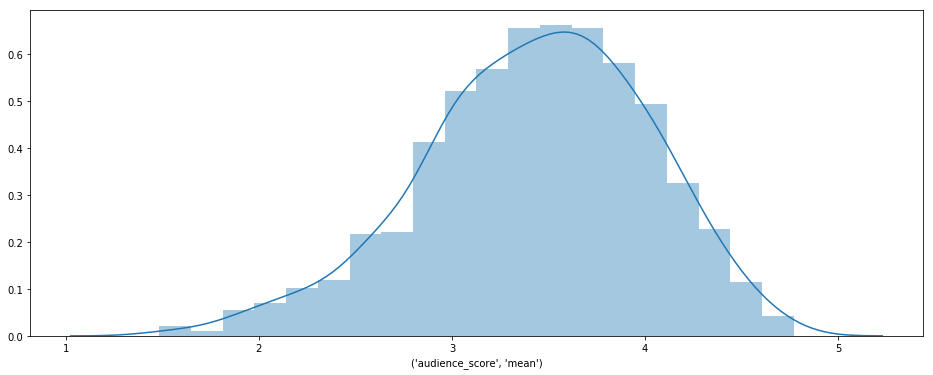

In [38]:
plt.figure(figsize=(16,6))
sns.distplot(df_bo_predictor["('audience_score', 'mean')"],bins=20)
plt.show()

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


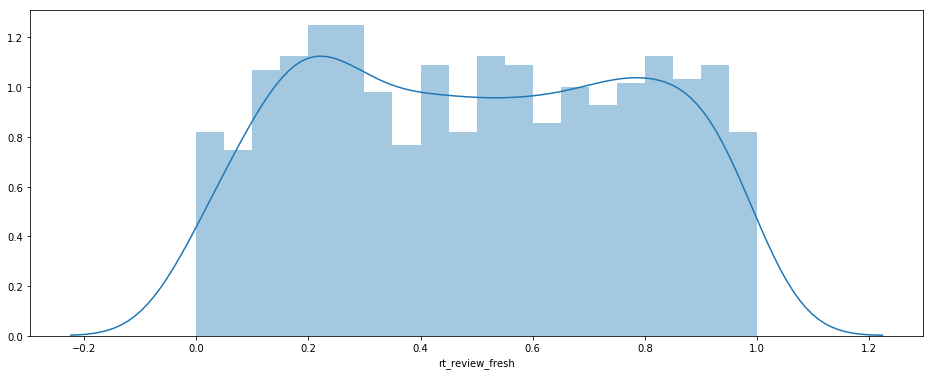

In [39]:
plt.figure(figsize=(16,6))
sns.distplot(df_bo_predictor['rt_review_fresh'], bins=20)
plt.show()

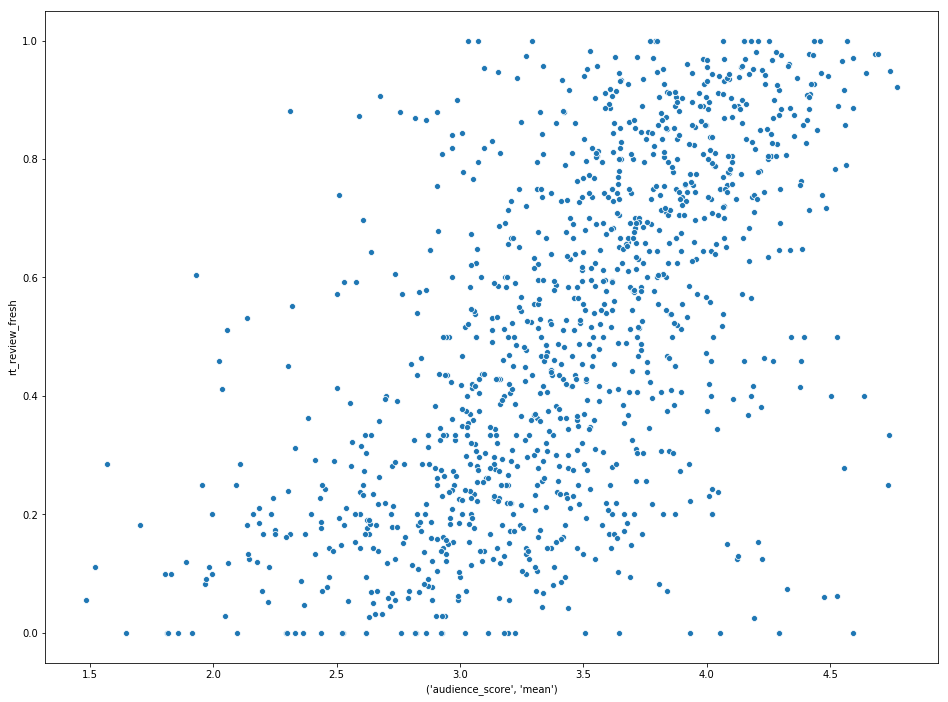

In [40]:
plt.figure(figsize=(16,12))
sns.scatterplot(x="('audience_score', 'mean')", y='rt_review_fresh', data=df_bo_predictor)
plt.show()

In [66]:
df_bo_predictor_cluster = df_bo_predictor[["('audience_cluster', '')",'bomojo_dom_boxoffice']].groupby(["('audience_cluster', '')"],as_index=True).mean()

In [68]:
df_bo_predictor_cluster.head()

,bomojo_dom_boxoffice
"('audience_cluster', '')",
0,5.114127e+07
1,5.108586e+07
2,3.853995e+07
3,5.154433e+07
4,9.874129e+07


c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


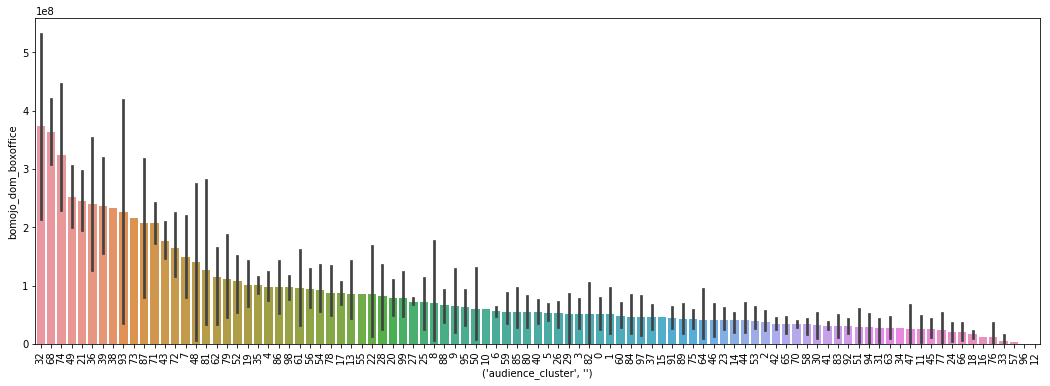

In [89]:
cluster_order = df_bo_predictor_cluster.sort_values(by='bomojo_dom_boxoffice', ascending=False)

plt.figure(figsize=(18,6))
g = sns.barplot(x="('audience_cluster', '')", y='bomojo_dom_boxoffice', data=df_bo_predictor, order=cluster_order.index)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.show()

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


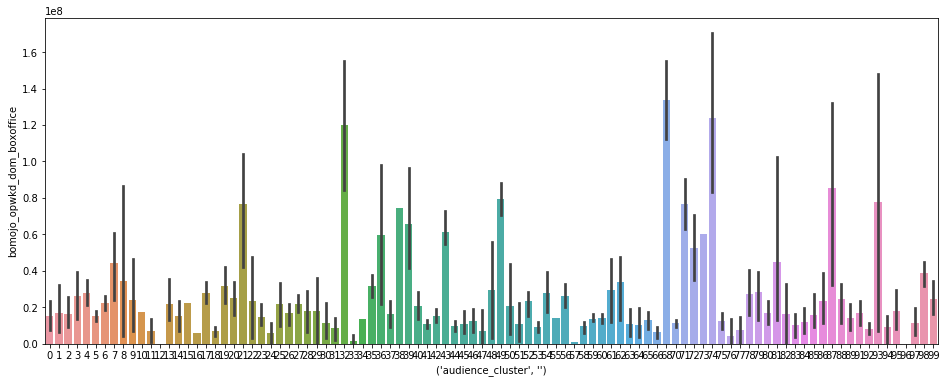

In [42]:
plt.figure(figsize=(16,6))
sns.barplot(x="('audience_cluster', '')", y='bomojo_opwkd_dom_boxoffice', data=df_bo_predictor)
plt.show()

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


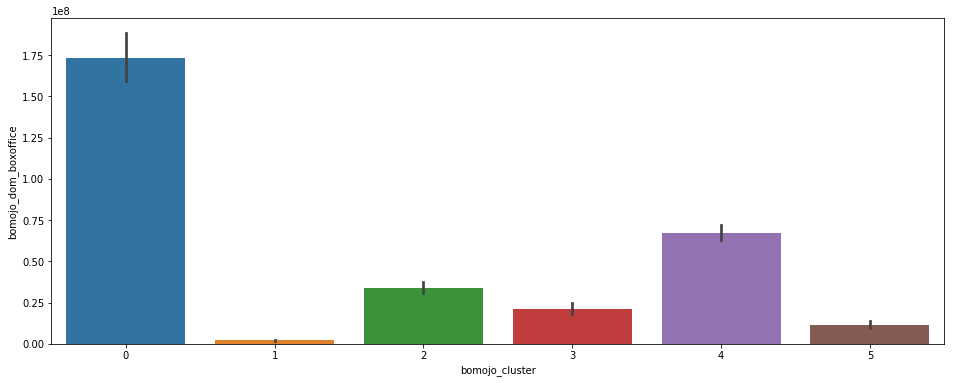

In [43]:
plt.figure(figsize=(16,6))
sns.barplot(x='bomojo_cluster', y='bomojo_dom_boxoffice', data=df_bo_predictor)
plt.show()

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


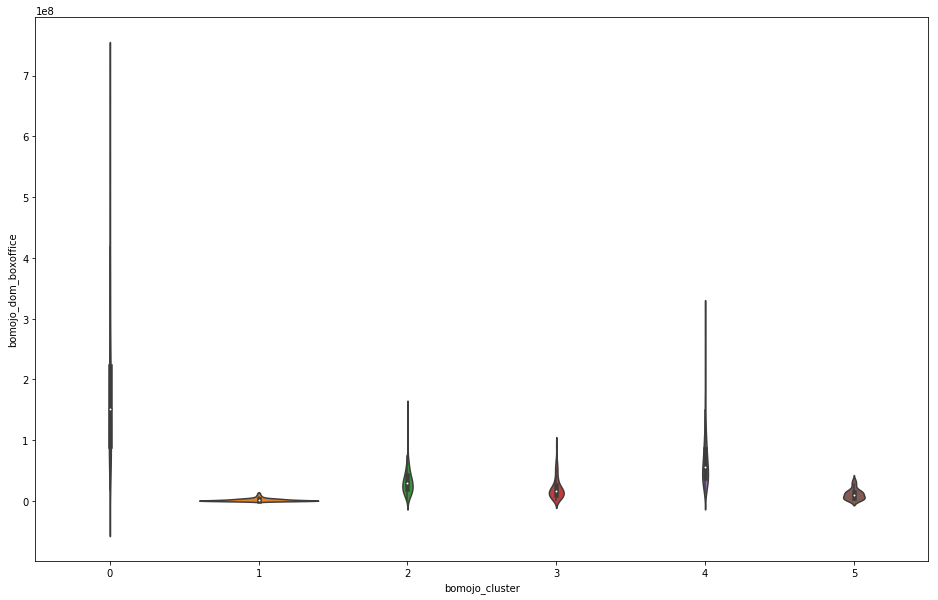

In [44]:
plt.figure(figsize=(16,10))
sns.violinplot(x='bomojo_cluster', y='bomojo_dom_boxoffice', data=df_bo_predictor)
plt.show()

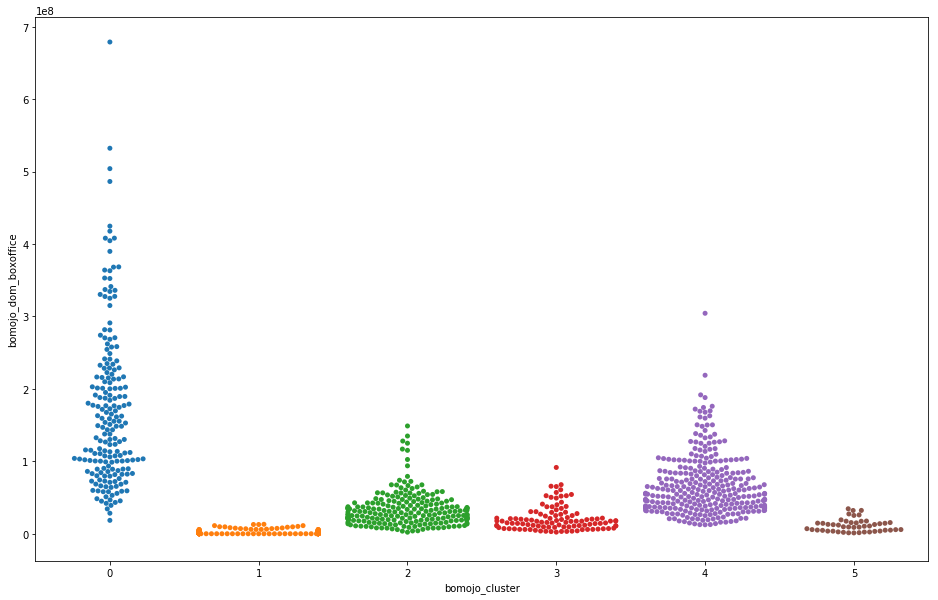

In [45]:
plt.figure(figsize=(16,10))
sns.swarmplot(x='bomojo_cluster', y='bomojo_dom_boxoffice', data=df_bo_predictor)
plt.show()

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


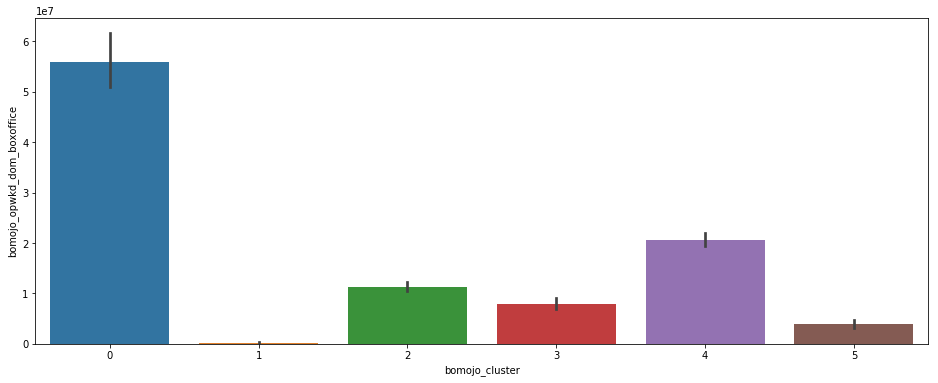

In [46]:
plt.figure(figsize=(16,6))
sns.barplot(x='bomojo_cluster', y='bomojo_opwkd_dom_boxoffice', data=df_bo_predictor)
plt.show()

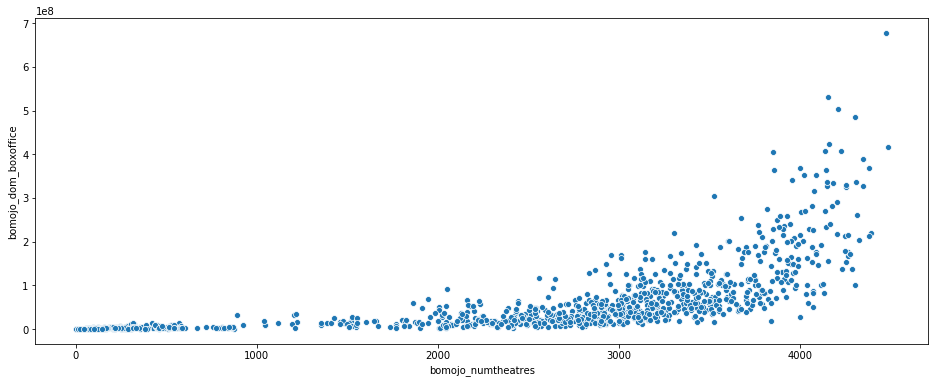

In [47]:
df_bo_predictor['log_boxoffice'] = np.log(df_bo_predictor.bomojo_dom_boxoffice)
df_bo_predictor['log_opwkd_boxoffice'] = np.log(df_bo_predictor.bomojo_opwkd_dom_boxoffice)

plt.figure(figsize=(16,6))
sns.scatterplot(x='bomojo_numtheatres', y='bomojo_dom_boxoffice', data=df_bo_predictor)
plt.show()

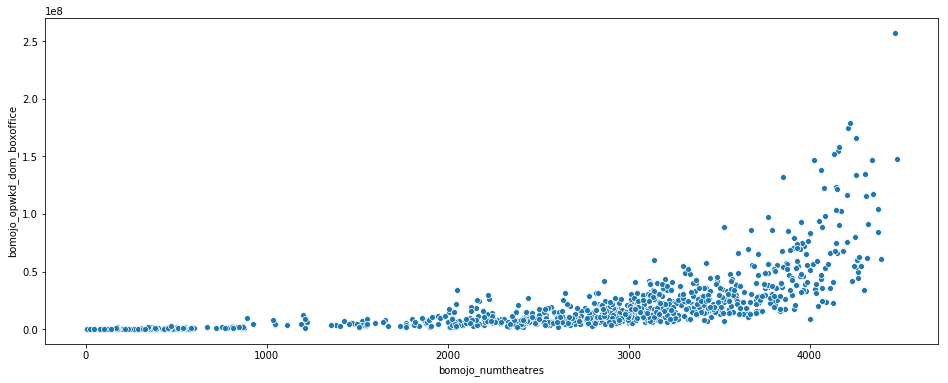

In [48]:
plt.figure(figsize=(16,6))
sns.scatterplot(x='bomojo_numtheatres', y='bomojo_opwkd_dom_boxoffice', data=df_bo_predictor)
plt.show()

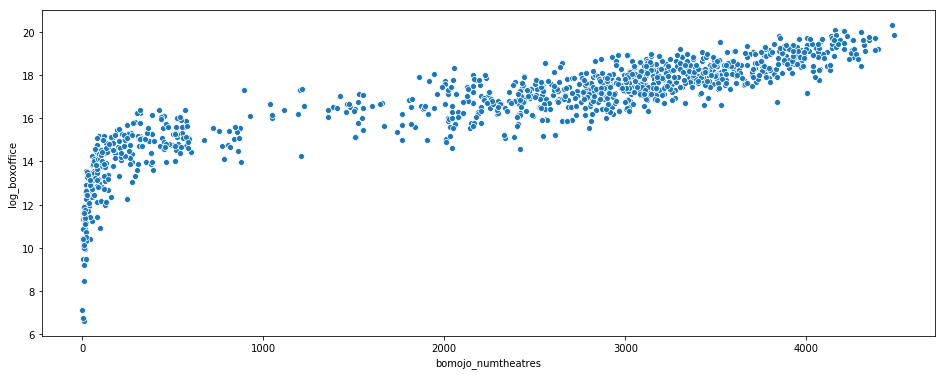

In [49]:
plt.figure(figsize=(16,6))
sns.scatterplot(x='bomojo_numtheatres', y='log_boxoffice', data=df_bo_predictor)
plt.show()

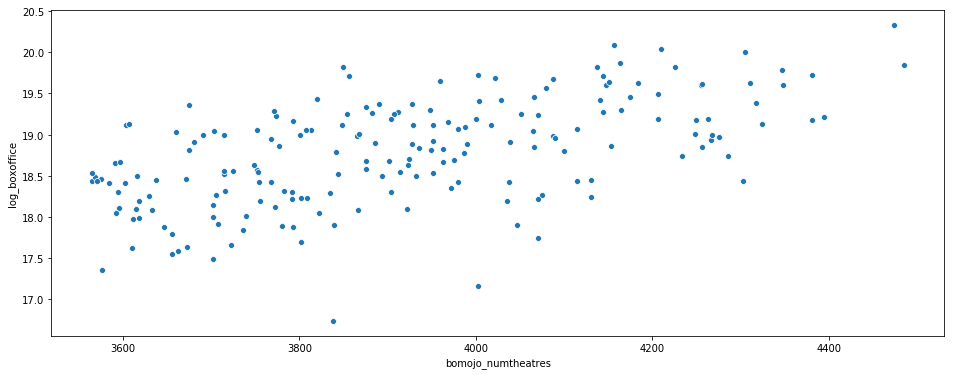

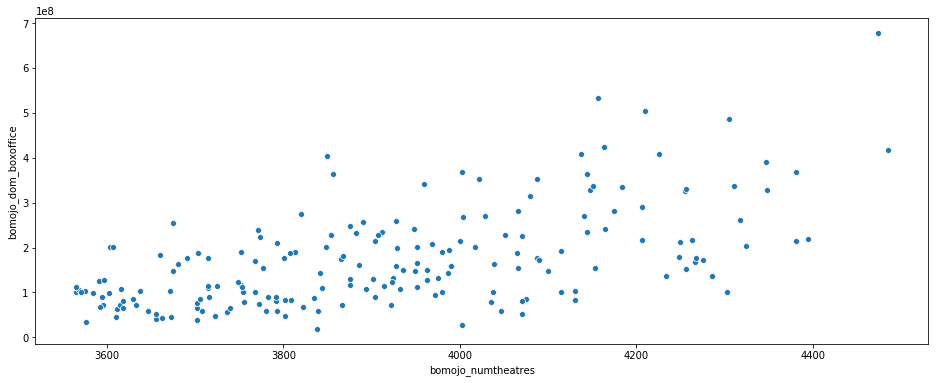

In [50]:
df_bo_predictor_cluster = df_bo_predictor[df_bo_predictor['bomojo_cluster'] == 0]

plt.figure(figsize=(16,6))
sns.scatterplot(x='bomojo_numtheatres', y='log_boxoffice', data=df_bo_predictor_cluster)
plt.show()

plt.figure(figsize=(16,6))
sns.scatterplot(x='bomojo_numtheatres', y='bomojo_dom_boxoffice', data=df_bo_predictor_cluster)
plt.show()

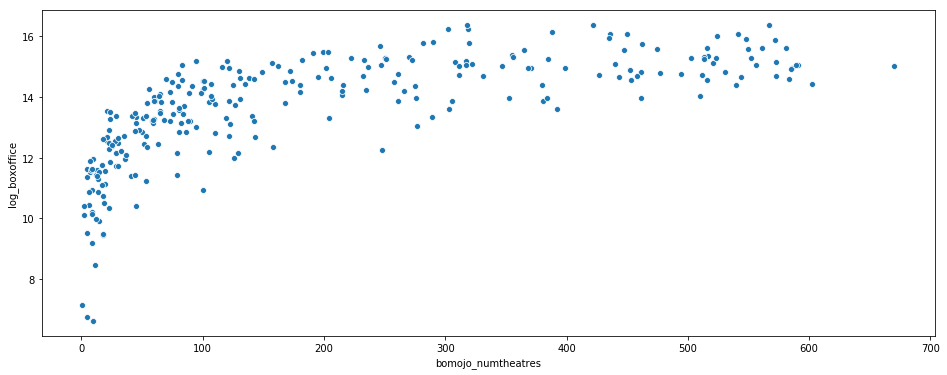

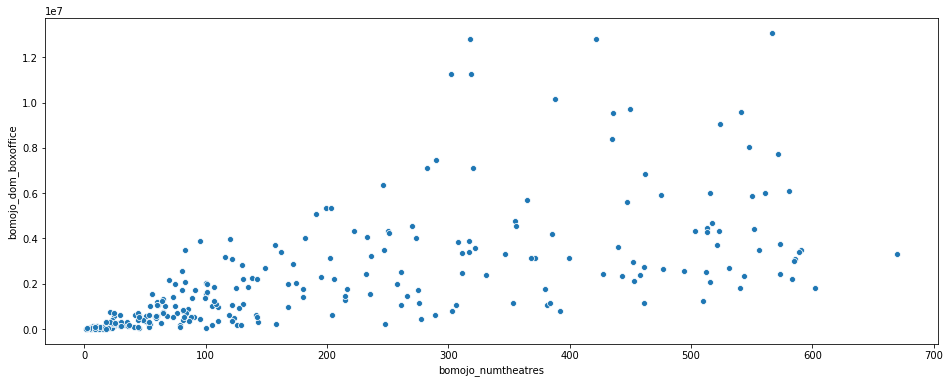

In [51]:
df_bo_predictor_cluster = df_bo_predictor[df_bo_predictor['bomojo_cluster'] == 1]

plt.figure(figsize=(16,6))
sns.scatterplot(x='bomojo_numtheatres', y='log_boxoffice', data=df_bo_predictor_cluster)
plt.show()

plt.figure(figsize=(16,6))
sns.scatterplot(x='bomojo_numtheatres', y='bomojo_dom_boxoffice', data=df_bo_predictor_cluster)
plt.show()

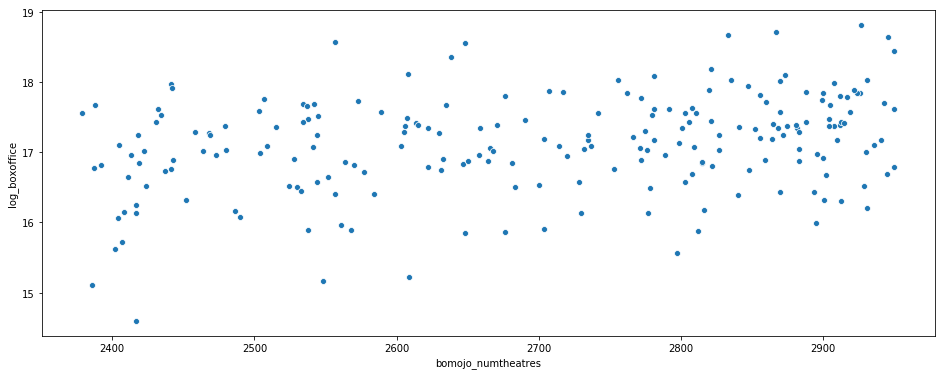

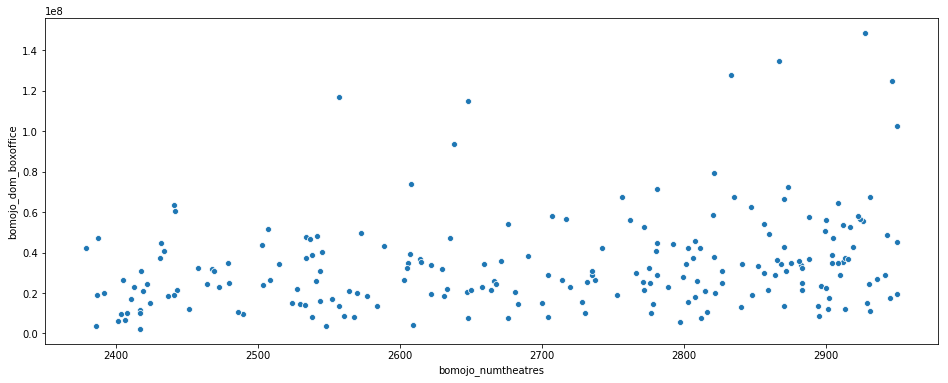

In [52]:
df_bo_predictor_cluster = df_bo_predictor[df_bo_predictor['bomojo_cluster'] == 2]

plt.figure(figsize=(16,6))
sns.scatterplot(x='bomojo_numtheatres', y='log_boxoffice', data=df_bo_predictor_cluster)
plt.show()

plt.figure(figsize=(16,6))
sns.scatterplot(x='bomojo_numtheatres', y='bomojo_dom_boxoffice', data=df_bo_predictor_cluster)
plt.show()

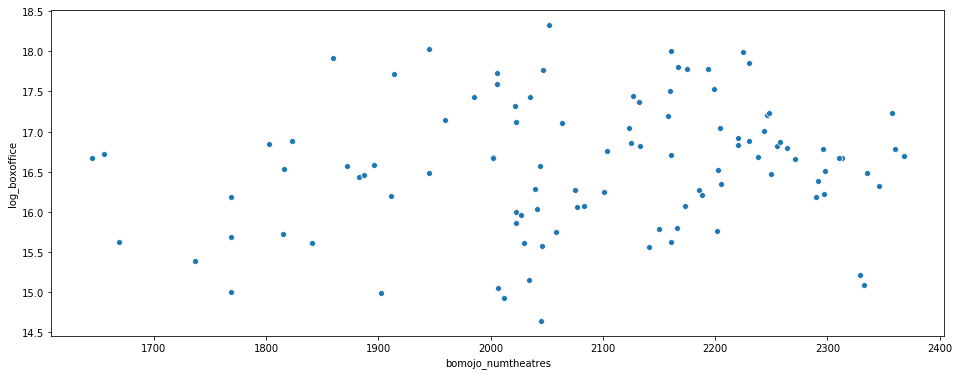

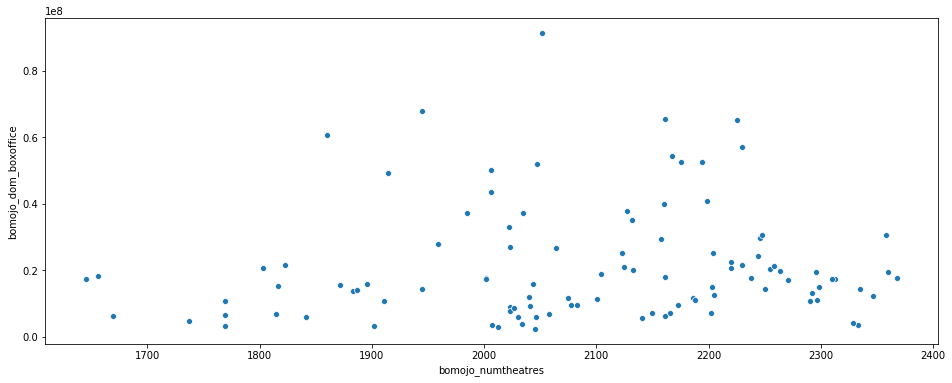

In [53]:
df_bo_predictor_cluster = df_bo_predictor[df_bo_predictor['bomojo_cluster'] == 3]

plt.figure(figsize=(16,6))
sns.scatterplot(x='bomojo_numtheatres', y='log_boxoffice', data=df_bo_predictor_cluster)
plt.show()

plt.figure(figsize=(16,6))
sns.scatterplot(x='bomojo_numtheatres', y='bomojo_dom_boxoffice', data=df_bo_predictor_cluster)
plt.show()

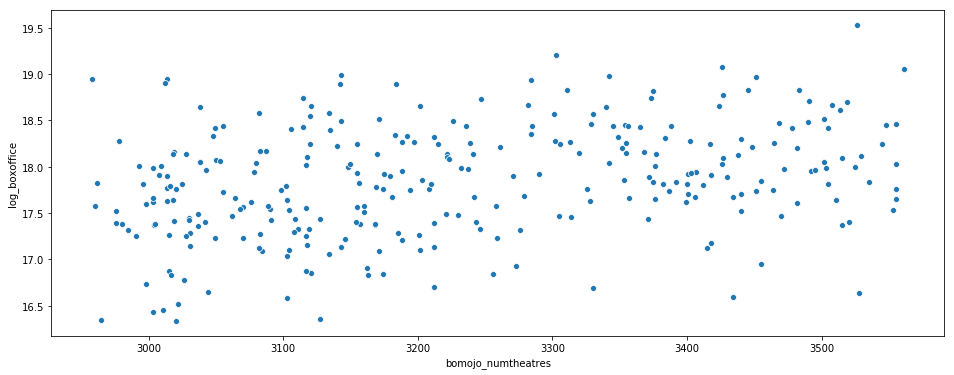

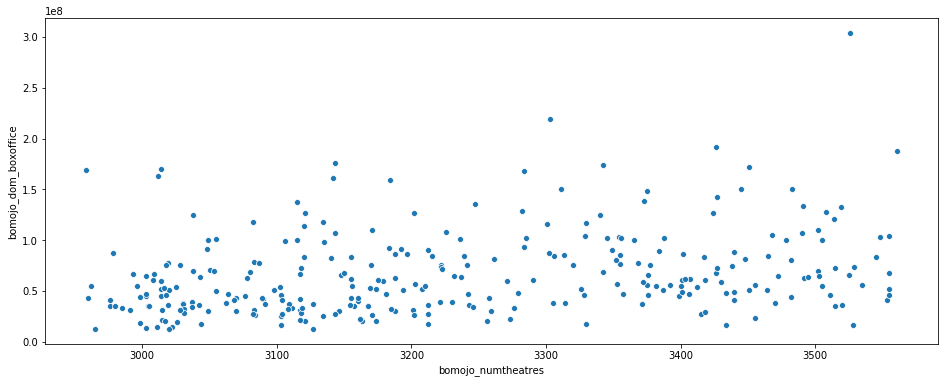

In [54]:
df_bo_predictor_cluster = df_bo_predictor[df_bo_predictor['bomojo_cluster'] == 4]

plt.figure(figsize=(16,6))
sns.scatterplot(x='bomojo_numtheatres', y='log_boxoffice', data=df_bo_predictor_cluster)
plt.show()

plt.figure(figsize=(16,6))
sns.scatterplot(x='bomojo_numtheatres', y='bomojo_dom_boxoffice', data=df_bo_predictor_cluster)
plt.show()

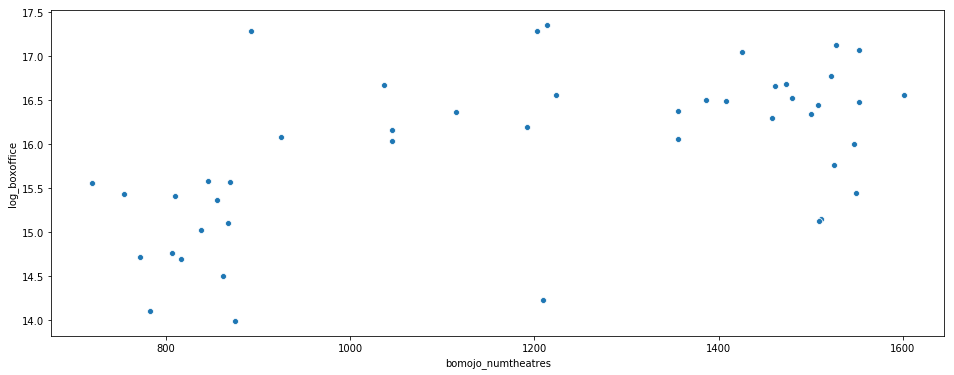

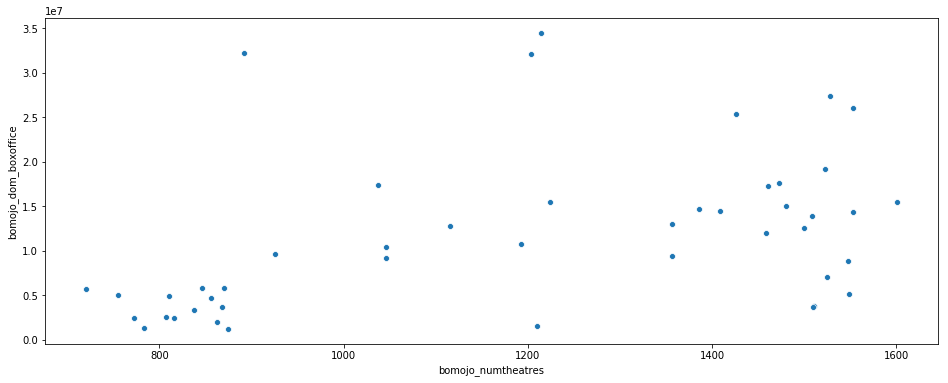

In [55]:
df_bo_predictor_cluster = df_bo_predictor[df_bo_predictor['bomojo_cluster'] == 5]

plt.figure(figsize=(16,6))
sns.scatterplot(x='bomojo_numtheatres', y='log_boxoffice', data=df_bo_predictor_cluster)
plt.show()

plt.figure(figsize=(16,6))
sns.scatterplot(x='bomojo_numtheatres', y='bomojo_dom_boxoffice', data=df_bo_predictor_cluster)
plt.show()

In [56]:
# NOTE: with using the bomojo clustering, no longer splitting the model into small and large models based on
# number of theaters at > or < 1k
#df_bo_predictor_small = df_bo_predictor[df_bo_predictor.bomojo_numtheatres <= 1000]
# df_bo_predictor_large = df_bo_predictor[df_bo_predictor.bomojo_numtheatres > 1000]

In [57]:
# plt.figure(figsize=(16,6))
# sns.scatterplot(x='bomojo_numtheatres', y='log_boxoffice', data=df_bo_predictor_large)
# plt.show()

In [58]:
# df_bo_predictor_small['log_theaters'] = np.log(df_bo_predictor.bomojo_numtheatres)

# plt.figure(figsize=(16,6))
# sns.scatterplot(x='log_theaters', y='log_boxoffice', data=df_bo_predictor_small)
# plt.show()

In [59]:
df_bo_predictor_distributor = df_bo_predictor.groupby(['bomojo_distributor'],as_index=False)['bomojo_dom_boxoffice'].agg(['min','max','mean','std','sum']).reset_index()

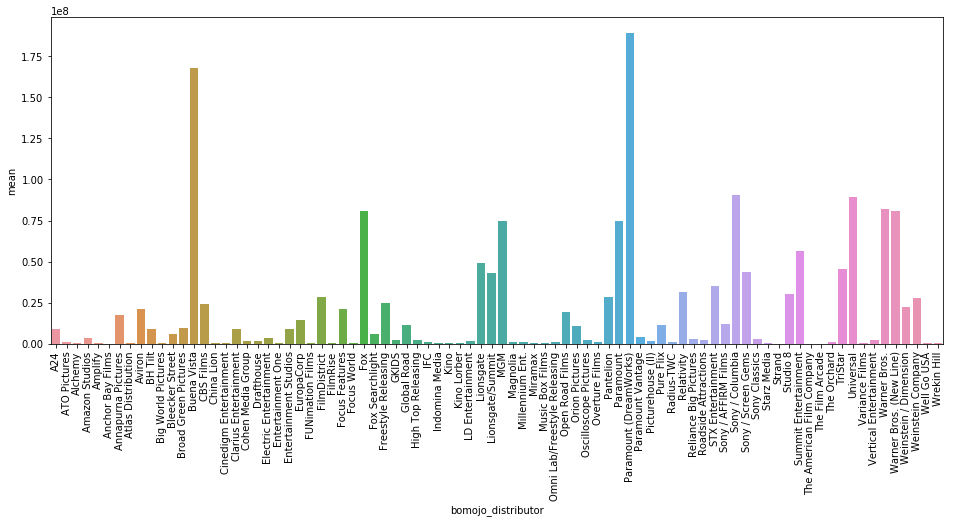

In [60]:
order = df_bo_predictor_distributor.sort_values(by='mean')

plt.figure(figsize=(16,6))
sns.barplot(x='bomojo_distributor',y='mean',data=df_bo_predictor_distributor)
plt.xticks(rotation=90)
plt.show()

In [61]:
df_bo_predictor_distributor.head()

,bomojo_distributor,min,max,mean,std,sum
0,A24,12544,44069456,8.950801e+06,1.404899e+07,98458809
1,ATO Pictures,366377,1042959,7.046680e+05,4.784157e+05,1409336
2,Alchemy,249083,608852,4.289675e+05,2.543951e+05,857935
3,Amazon Studios,1441705,4533425,3.140312e+06,1.435683e+06,12561250
4,Amplify,91302,257706,1.745040e+05,1.176654e+05,349008


In [62]:
df_bo_predictor_distributor = df_bo_predictor_distributor.dropna()
distrib_cluster = df_bo_predictor_distributor[['min','max','mean','std','sum']]

For n_clusters = 2 The average silhouette_score is : 0.9046192022018628
For n_clusters = 3 The average silhouette_score is : 0.8599513196862185
For n_clusters = 4 The average silhouette_score is : 0.8638855701394538
For n_clusters = 5 The average silhouette_score is : 0.7795406391816775
For n_clusters = 6 The average silhouette_score is : 0.788329946193951
For n_clusters = 7 The average silhouette_score is : 0.7782356714624167
For n_clusters = 8 The average silhouette_score is : 0.7499059138973603
For n_clusters = 9 The average silhouette_score is : 0.6575741031819387
For n_clusters = 10 The average silhouette_score is : 0.6475778601039085
For n_clusters = 11 The average silhouette_score is : 0.6295542162380121
For n_clusters = 12 The average silhouette_score is : 0.6283409529372145
For n_clusters = 13 The average silhouette_score is : 0.6031318038852395
For n_clusters = 14 The average silhouette_score is : 0.602852407086494
For n_clusters = 15 The average silhouette_score is : 0.50452

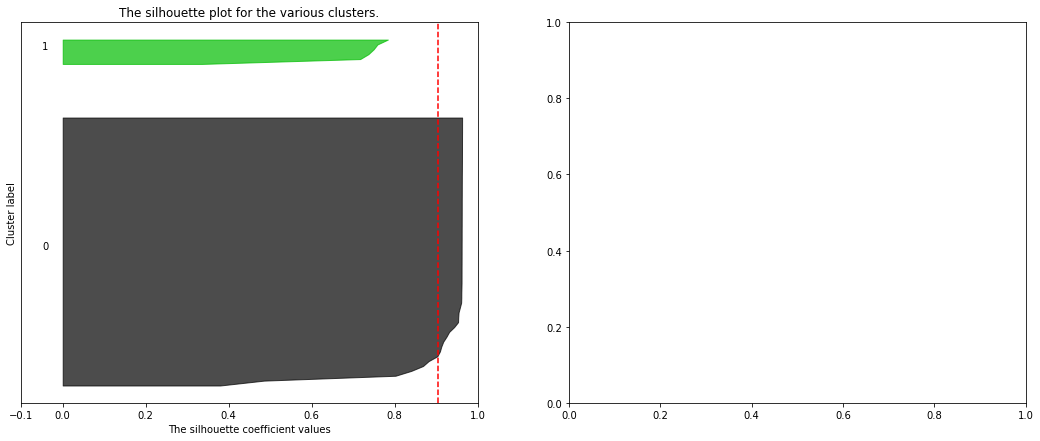

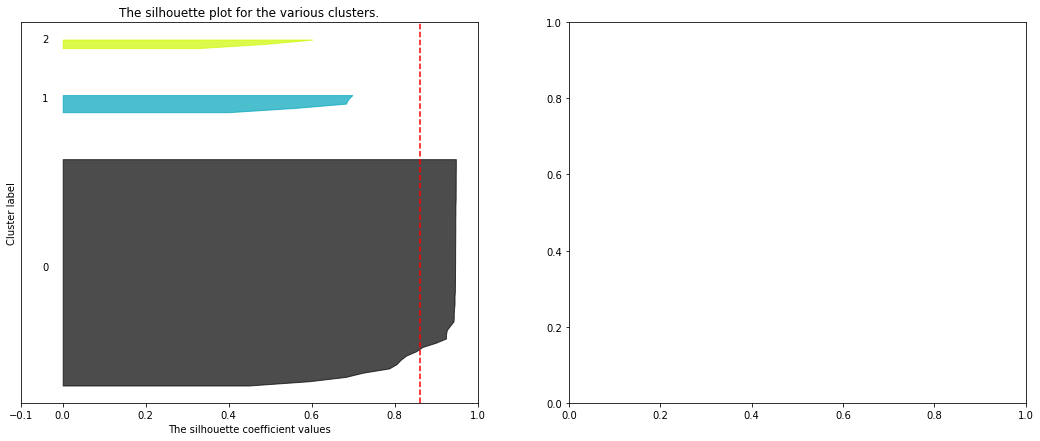

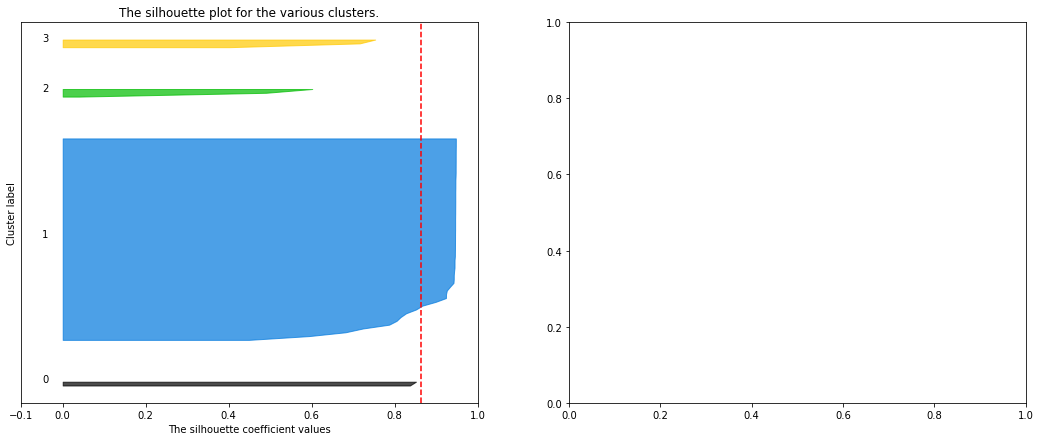

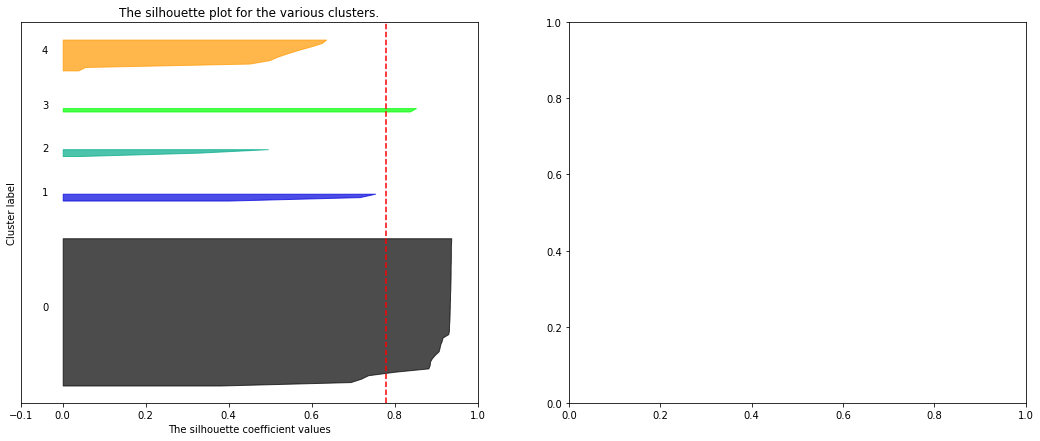

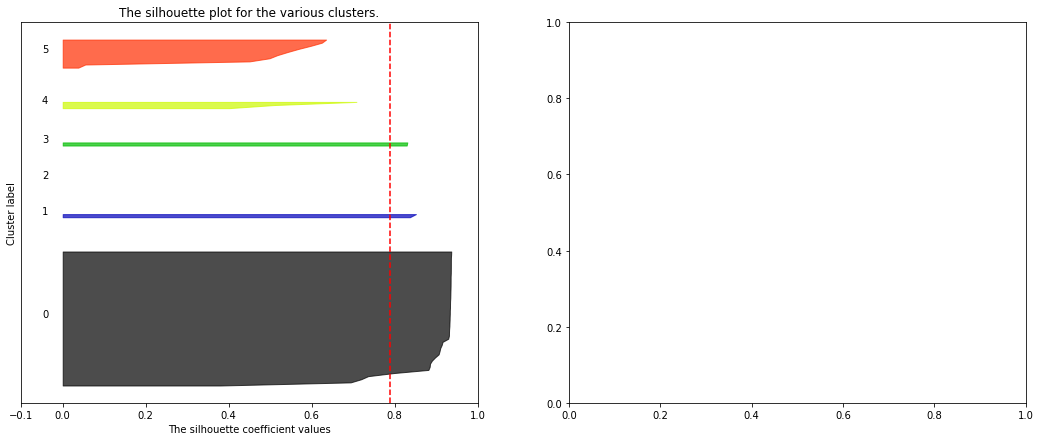

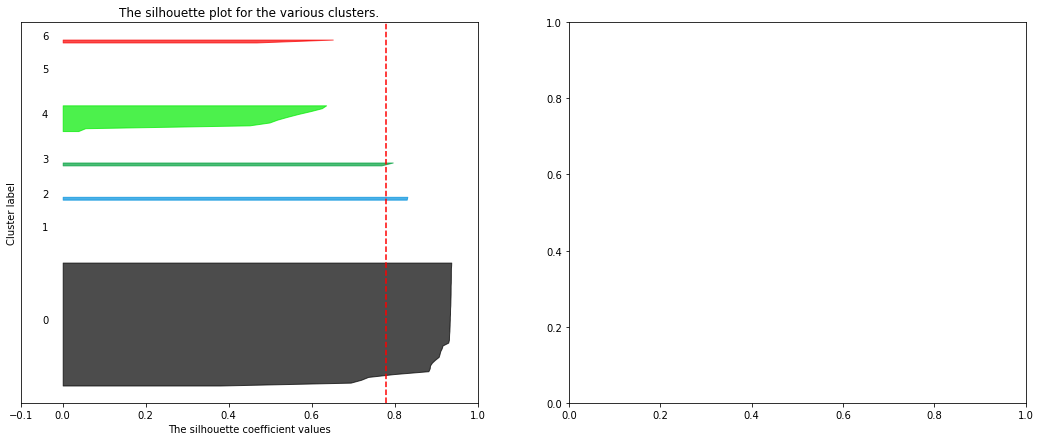

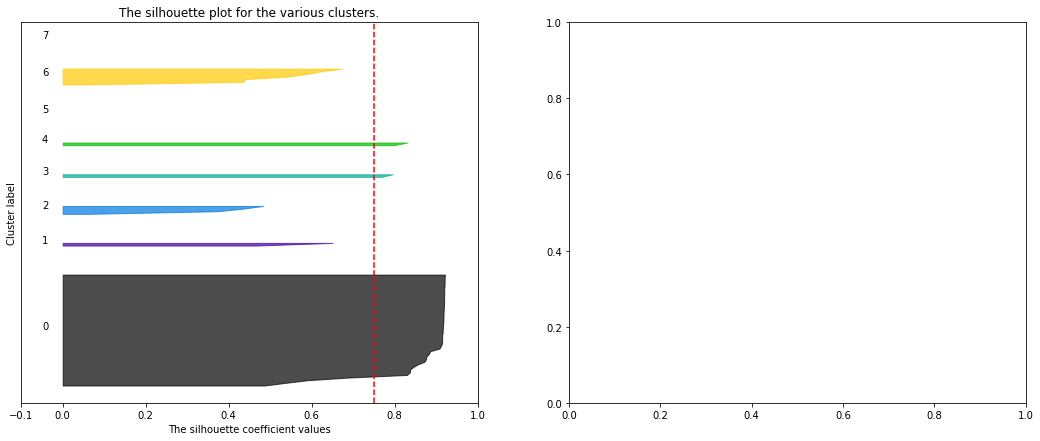

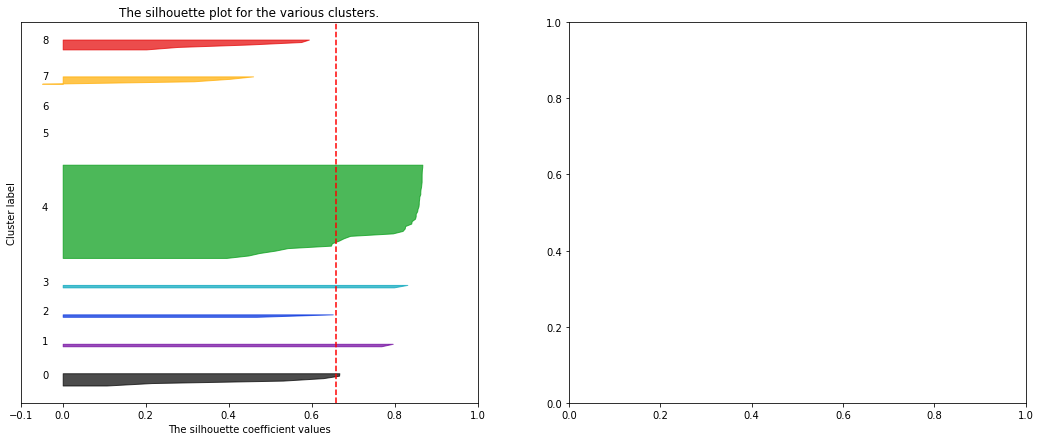

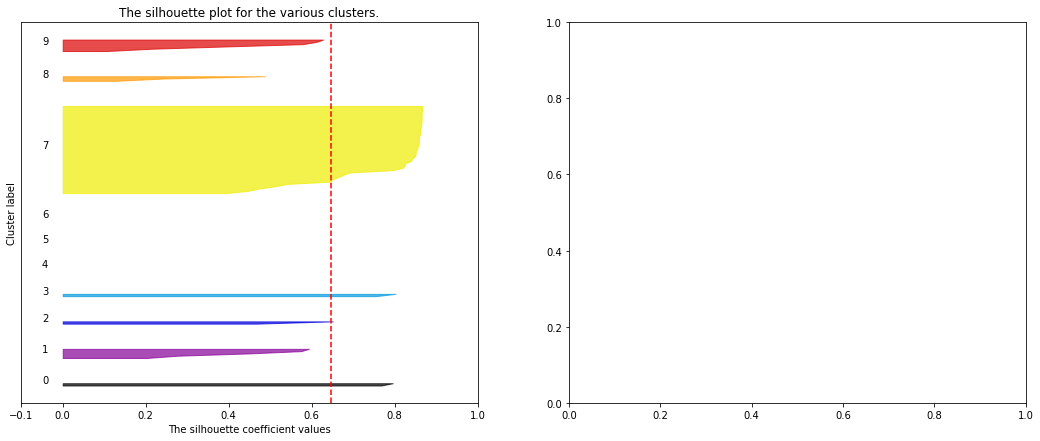

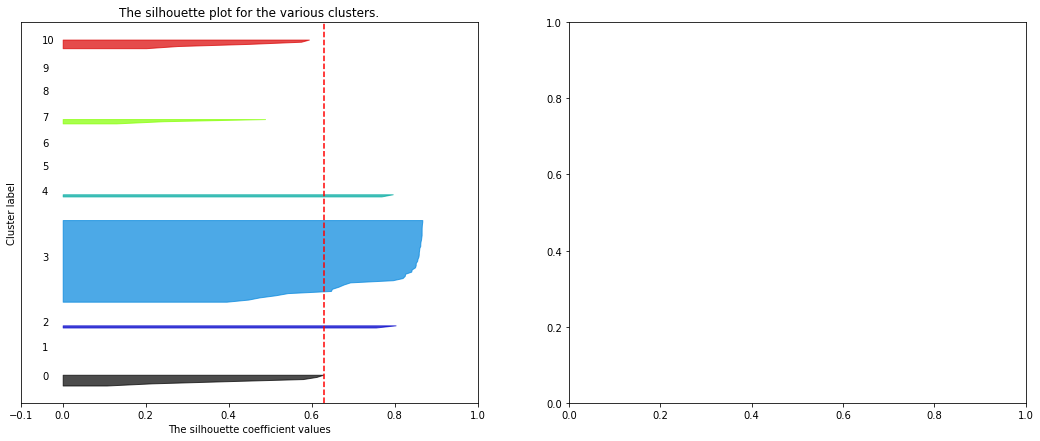

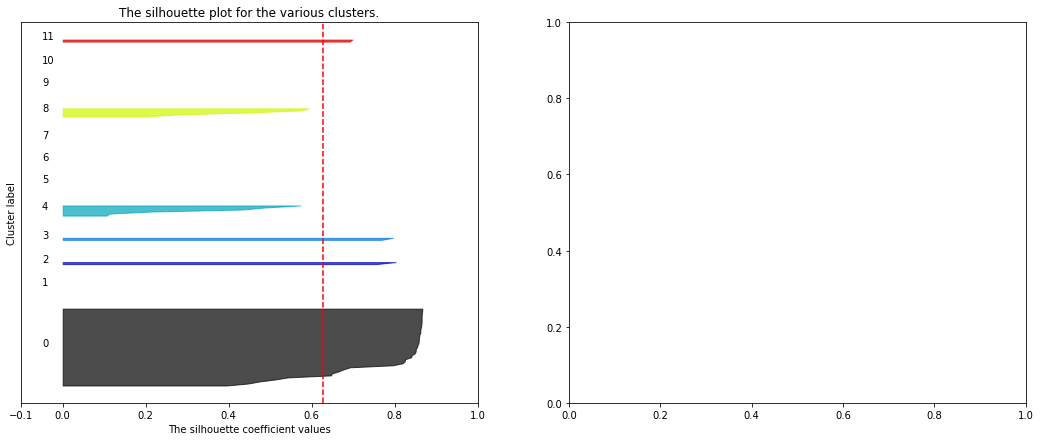

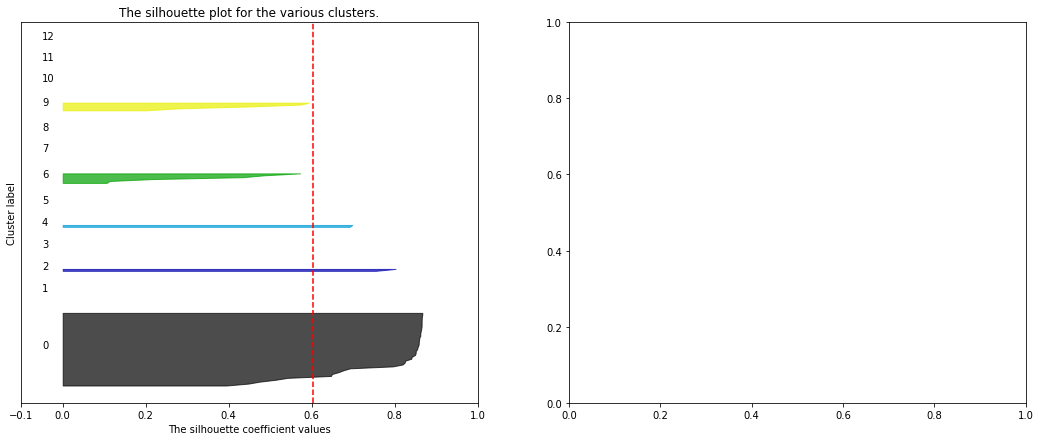

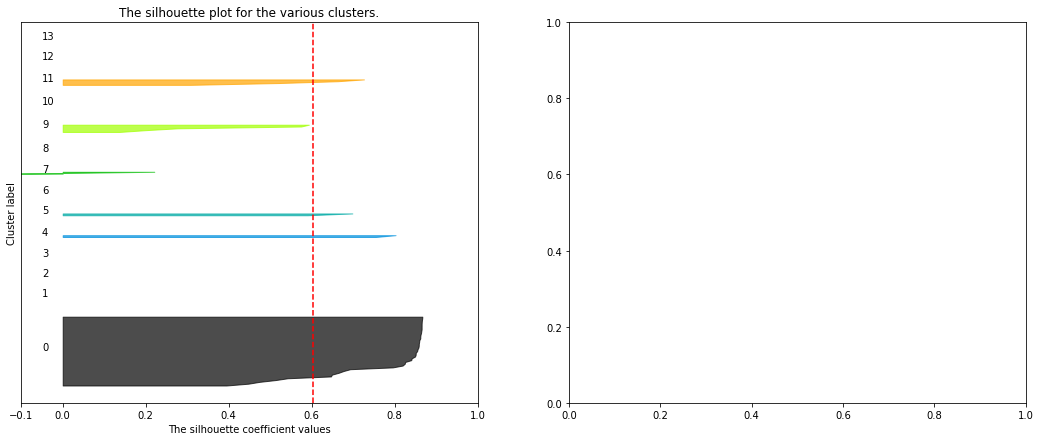

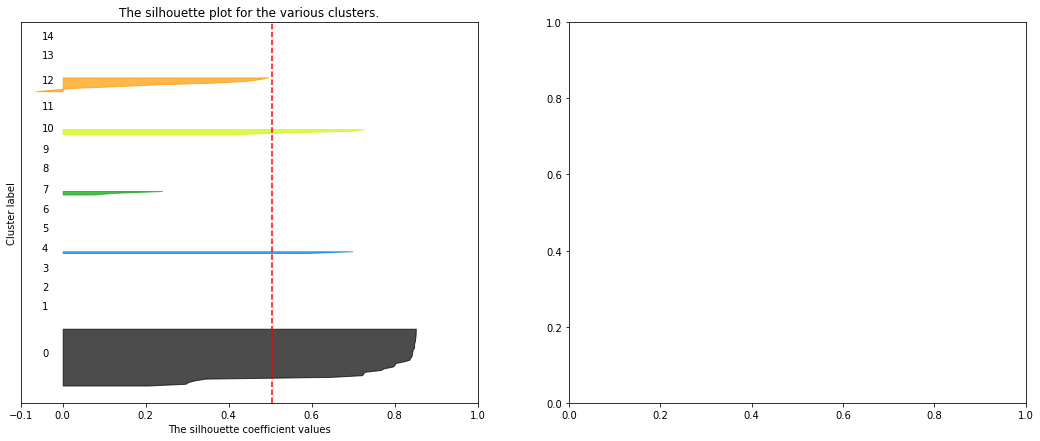

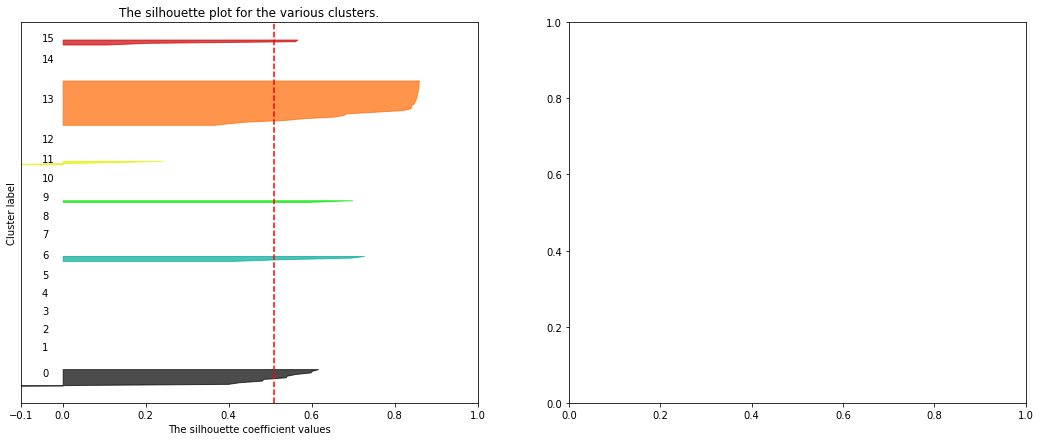

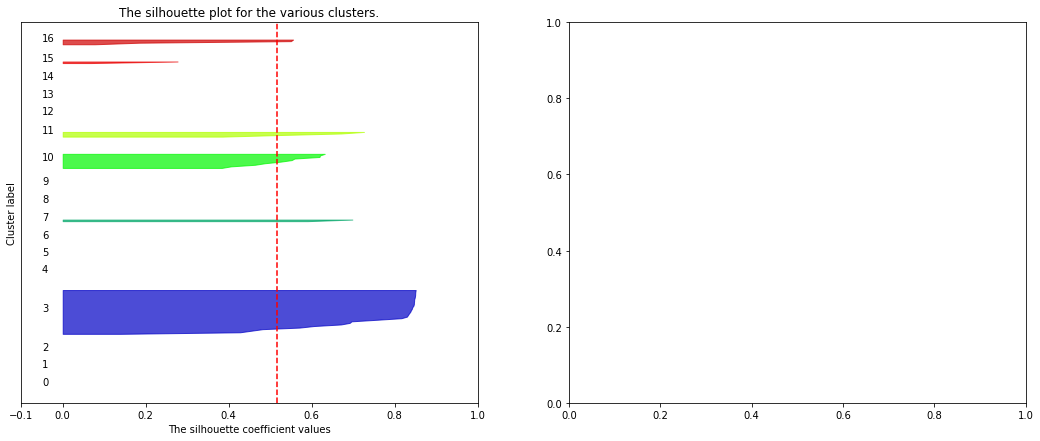

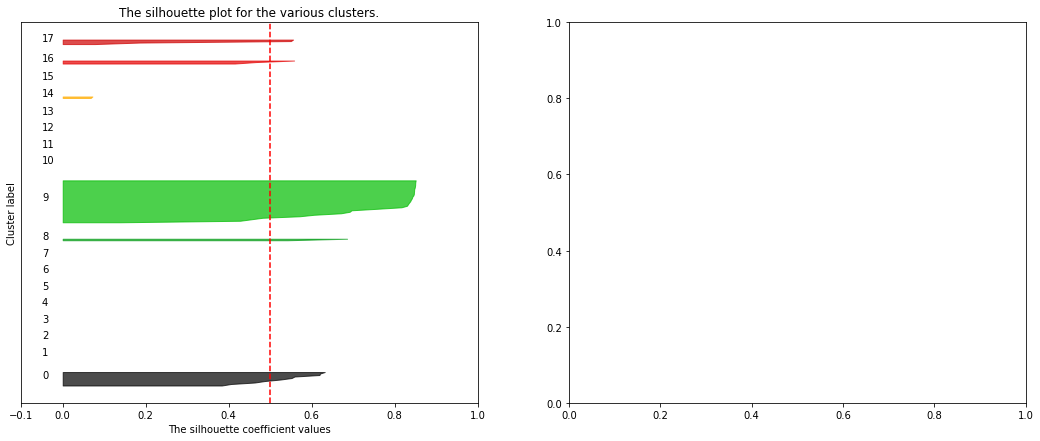

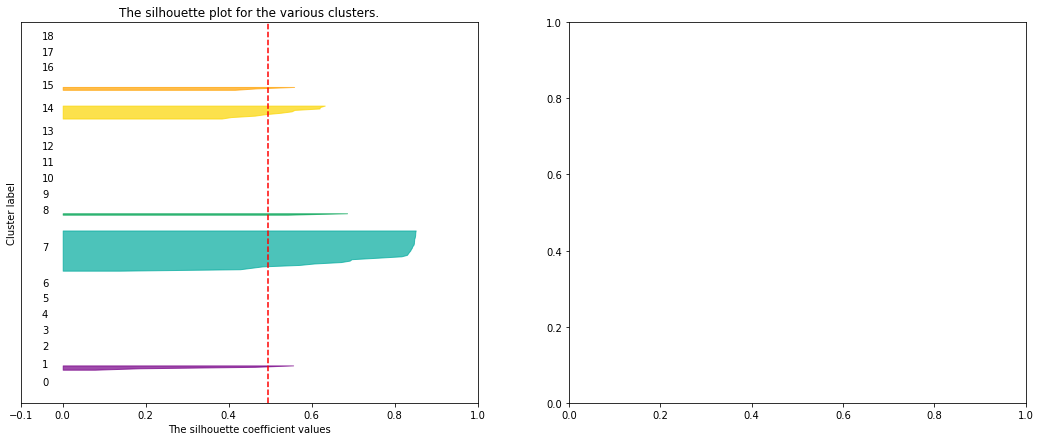

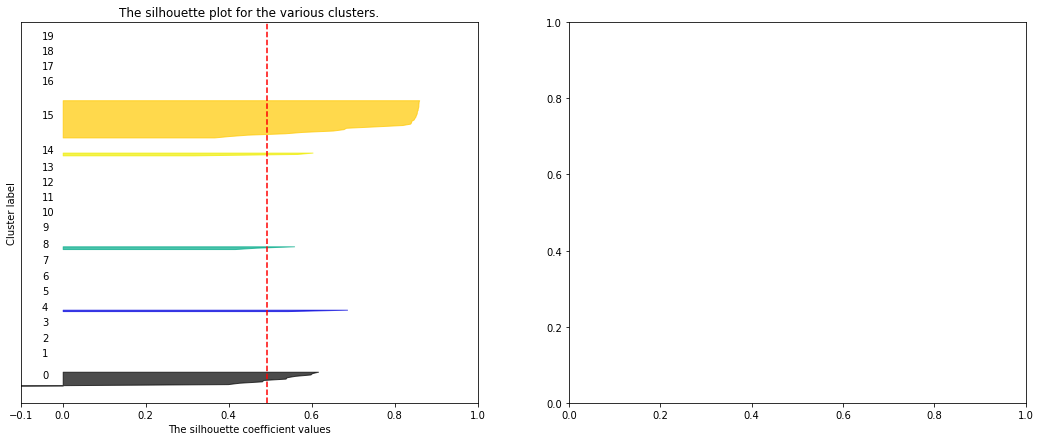

In [63]:
# use silhouette plots for number of cluster identification
# print out a bunch of samples where cluster == 2 (whatever) and identify similarities among points
range_n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

silhouette_scores(distrib_cluster, range_n_clusters, KMeans)

In [64]:
df_bo_predictor_distributor['distrib_cluster'] = KMeans(n_clusters=4, random_state=42).fit_predict(distrib_cluster)
df_bo_predictor = df_bo_predictor.merge(df_bo_predictor_distributor[['bomojo_distributor','distrib_cluster']],
                                        how='left', on='bomojo_distributor')

In [65]:
df_bo_predictor.columns

Index(['bomojo_link', 'rottentomatoes_link', 'metacritic_link', 'imdb_link',
       'bomojo_url', 'bomojo_title', 'bomojo_genre', 'bomojo_dom_releasedate',
       'bomojo_mpaa_rating', 'bomojo_distributor', 'bomojo_dom_boxoffice',
       'bomojo_ww_boxoffice', 'bomojo_opwkd_dom_boxoffice',
       'bomojo_numtheatres', 'month', 'bomojo_cluster', 'rt_review_fresh',
       'rt_review_rotten', 'mc_score', '('rt_url', '')',
       '('audience_score', 'mean')', '('audience_score', 'std')',
       '('audience_cluster', '')', '('audience_text', '')', 'log_boxoffice',
       'log_opwkd_boxoffice', 'distrib_cluster'],
      dtype='object')

### Model #1 -- without RT audience clusters

In [385]:
df_bo_predictor = df_bo_predictor.dropna()

In [386]:
# linear regression for box office results
X = df_bo_predictor[['bomojo_mpaa_rating', 'bomojo_numtheatres', 'bomojo_genre',
                     'month', 'bomojo_cluster', 'rt_review_fresh','mc_score',
                     "('audience_score', 'mean')", "('audience_score', 'std')", 'distrib_cluster'
                          ]]
Y = df_bo_predictor.bomojo_dom_boxoffice
X = pd.get_dummies(X)

In [387]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=43)

In [388]:
pd.set_option('display.max_columns',500)

In [389]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

print('Coefficients: \n', lr.coef_)
print('Intercept: \n', lr.intercept_)
print('R-squared: \n', lr.score(X_train, y_train))

Coefficients: 
 [ 4.03195465e+04 -1.32359626e+07  4.32946825e+07  1.28277129e+05
  1.87377553e+07  4.43148770e+06 -6.97552389e+06  5.98579525e+06
 -8.64387085e+05 -4.93300909e+07  1.27478199e+07  5.32399749e+06
  6.65613864e+06  1.94807267e+07  8.71479235e+06  5.13272401e+07
 -1.85711756e+07  6.33099202e+06 -1.90899389e+07 -1.19539635e+07
 -3.78991105e+06 -1.20379665e+07  1.44415764e+07 -2.03670991e+06
 -4.48872096e+06  4.27891705e+06 -2.01752560e+06 -1.15634140e+07
  1.01948599e+06 -2.48145296e+07 -1.34173049e+07 -2.72753922e+06
 -1.74485846e+07 -2.16402961e+06  2.94004817e+06  1.11625485e+07
 -3.56317342e+07 -7.13429196e+06 -3.15280414e+07  2.26809277e+07
 -2.82251785e+07  1.92827471e+07 -5.70578963e+04  2.15654127e+07
  2.78641189e+07 -6.54610966e+06  3.68015494e+06 -1.20987062e+07
  2.50556201e+07  2.12994050e+07 -9.28016790e+06 -4.18079396e+06
  1.28260699e+07  8.70324936e+06  2.03924123e+07  1.19417651e+06
  5.32243904e+06  2.94107394e+07  1.29357316e+07  1.23902892e+07
  4.44076

In [390]:
y_pred = lr.predict(X_test)

In [392]:
print('Mean Absolute Error: %.3f' % metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.3f' % metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Median Absolute Error: %.3f' % np.sqrt(metrics.median_absolute_error(y_test, y_pred)))

Mean Absolute Error: 32013088.367
Mean Squared Error: 1836831808017802.500
Root Mean Squared Error: 42858275.840
Median Absolute Error: 4802.970


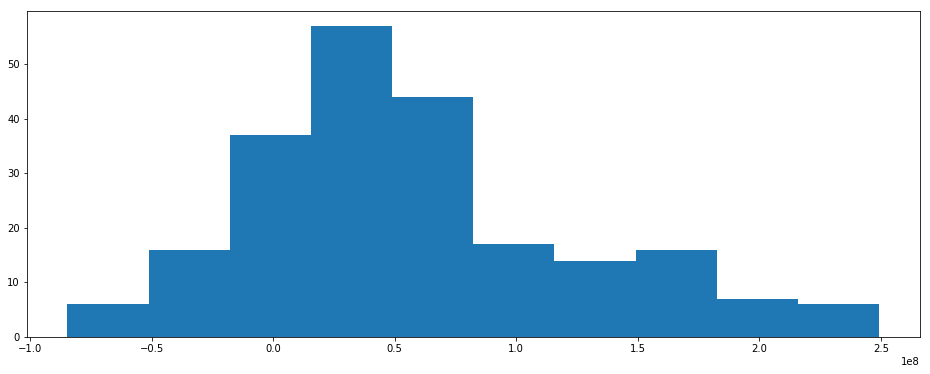

In [393]:
plt.figure(figsize=(16,6))
plt.hist(y_pred)
plt.show()

### Model #2 -- WITH RT audience clusters

In [394]:
# linear regression for box office results
X = df_bo_predictor[['bomojo_mpaa_rating', 'bomojo_numtheatres', 'bomojo_genre',
                     'month', 'bomojo_cluster', 'rt_review_fresh','mc_score',
                     "('audience_score', 'mean')", "('audience_score', 'std')", 'distrib_cluster',
                     "('audience_cluster', '')"
                          ]]
Y = df_bo_predictor.bomojo_dom_boxoffice
X = pd.get_dummies(X)

In [395]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y, test_size=0.1, random_state=42)

In [396]:
lr = linear_model.LinearRegression()

lr.fit(X_train2, y_train2)

print('Coefficients: \n', lr.coef_)
print('Intercept: \n', lr.intercept_)
print('R-squared: \n', lr.score(X_train2, y_train2))

Coefficients: 
 [ 3.91113517e+04 -1.25665429e+07  3.98442924e+07  1.68059992e+05
  1.98125877e+07  4.46541023e+06 -7.00642084e+06 -7.00094560e+04
  1.24772801e+07 -4.17286648e+06 -4.03458861e+07  6.41090802e+06
  6.78901900e+06  1.89976954e+06  1.69417759e+07  9.75270577e+06
  5.80391563e+07 -2.14766961e+07  3.72549264e+06 -2.08576234e+07
 -1.96796939e+04  1.42752914e+07 -9.36738052e+06  8.62434921e+06
  1.09938148e+06 -2.80123701e+06  3.52507059e+06 -3.94558618e+06
 -1.32048263e+07  1.86356586e+06 -2.10794382e+07  4.27587493e+06
 -9.22344544e+05 -1.82149653e+07 -1.05878504e+07  3.23064496e+06
  8.55591484e+06 -3.10178820e+07 -1.60776610e+07 -7.22566395e+06
  2.26680404e+07 -2.67962248e+07  1.91946071e+07  5.85413557e+05
  2.48020044e+07  2.81999847e+07  1.86264515e-08  2.00683383e+06
 -2.23573362e+07  8.89513353e+06  8.15927142e+06 -1.20330420e+07
 -9.29843780e+06  1.15326370e+07  9.70618158e+06  1.29414186e+07
 -4.02294239e+06 -2.77624227e+05  1.51846453e+07  4.67917402e+06
  6.90383

In [397]:
y_pred2 = lr.predict(X_test2)

(array([ 1.,  2., 10., 23., 26., 23., 10.,  5.,  6.,  4.]),
 array([-1.08698540e+08, -7.62879402e+07, -4.38773404e+07, -1.14667407e+07,
         2.09438591e+07,  5.33544588e+07,  8.57650586e+07,  1.18175658e+08,
         1.50586258e+08,  1.82996858e+08,  2.15407458e+08]),
 <a list of 10 Patch objects>)

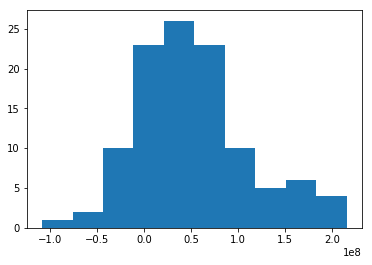

In [398]:
plt.hist(y_pred2)

### With RT Audience Cluster

In [399]:
print('Mean Absolute Error: %.3f' % metrics.mean_absolute_error(y_test2, y_pred2))  
print('Mean Squared Error: %.3f' % metrics.mean_squared_error(y_test2, y_pred2))  
print('Root Mean Squared Error: %.3f' % np.sqrt(metrics.mean_squared_error(y_test2, y_pred2)))
print('Median Absolute Error: %.3f' % np.sqrt(metrics.median_absolute_error(y_test2, y_pred2)))

Mean Absolute Error: 27570891.758
Mean Squared Error: 1291384498585663.250
Root Mean Squared Error: 35935838.638
Median Absolute Error: 4532.540


### WithOUT RT Audience Cluster

In [400]:
print('Mean Absolute Error: %.3f' % metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.3f' % metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Median Absolute Error: %.3f' % np.sqrt(metrics.median_absolute_error(y_test, y_pred)))

Mean Absolute Error: 32013088.367
Mean Squared Error: 1836831808017802.500
Root Mean Squared Error: 42858275.840
Median Absolute Error: 4802.970


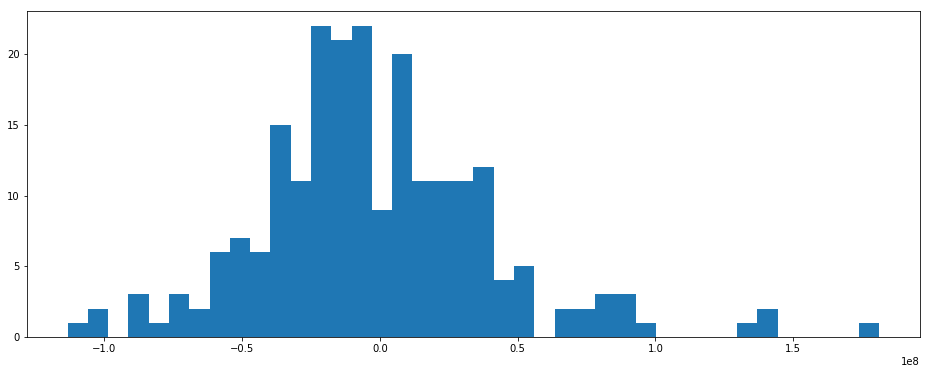

In [401]:
plt.figure(figsize=(16,6))
plt.hist(y_test - y_pred, bins=40)
plt.show()

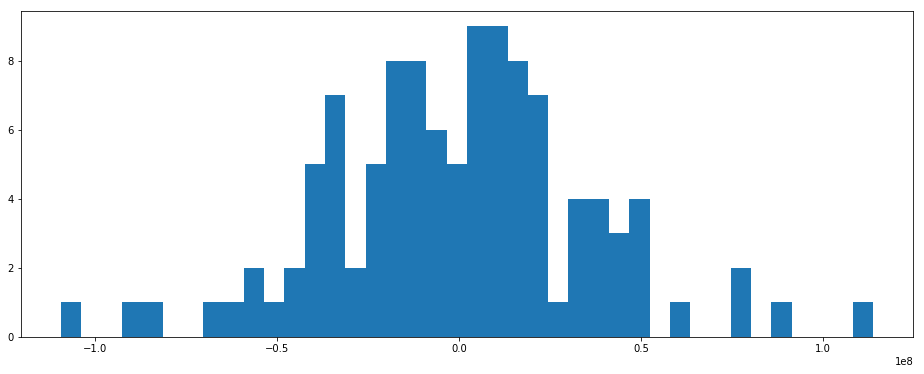

In [402]:
plt.figure(figsize=(16,6))
plt.hist(y_test2 - y_pred2, bins=40)
plt.show()

In [ ]:
# look at quantiles for 50% of dataset
# look at relative error, true minus predicted divided by the true

In [403]:
# #remove outlier predictions until we can identify why they're outliers
# X_test_2 = X_test.drop([709,952])
# y_test_2 = y_test.drop([709,952])

# y_pred_2 = lr.predict(X_test_2)

In [404]:
# for comparison when using log box office
compare_df = pd.DataFrame({'actual_boxoffice':y_test,
                          'predicted_boxoffice':y_pred},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df['difference'] = abs(compare_df['actual_boxoffice'] - compare_df['predicted_boxoffice'])
compare_df['difference %'] = abs(compare_df['predicted_boxoffice'] / compare_df['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df[compare_df['difference %'] > 100]

In [416]:
# for comparison when using log box office
compare_df_RT = pd.DataFrame({'actual_boxoffice':y_test2,
                          'predicted_boxoffice':y_pred2},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df_RT['difference'] = abs(compare_df_RT['actual_boxoffice'] - compare_df_RT['predicted_boxoffice'])
compare_df_RT['difference %'] = abs(compare_df_RT['predicted_boxoffice'] / compare_df_RT['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses_RT = compare_df_RT[compare_df_RT['difference %'] > 100]

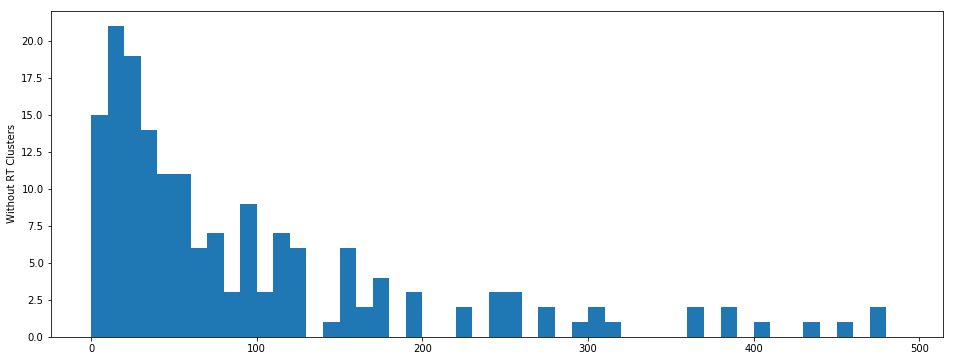

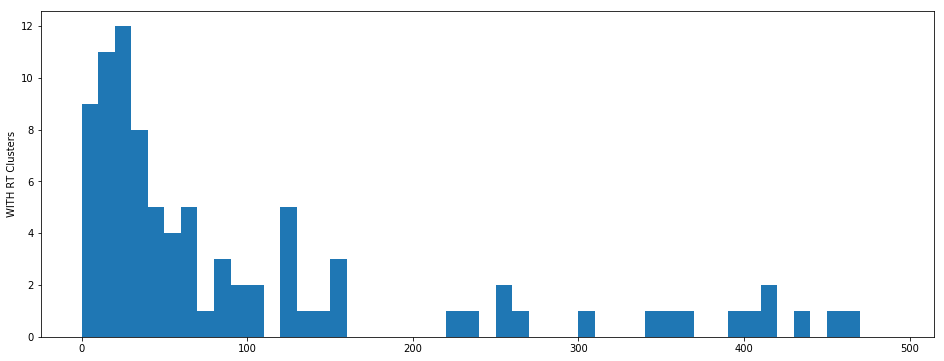

In [418]:
plt.figure(figsize=(16,6))
plt.hist(compare_df['difference %'], bins=np.arange(0,500,10))
plt.ylabel('Without RT Clusters')
plt.show()

plt.figure(figsize=(16,6))
plt.hist(compare_df_RT['difference %'], bins=np.arange(0,500,10))
plt.ylabel('WITH RT Clusters')
plt.show()

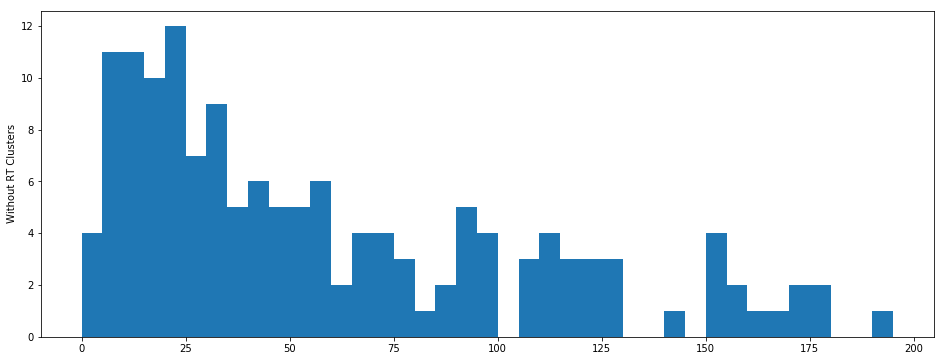

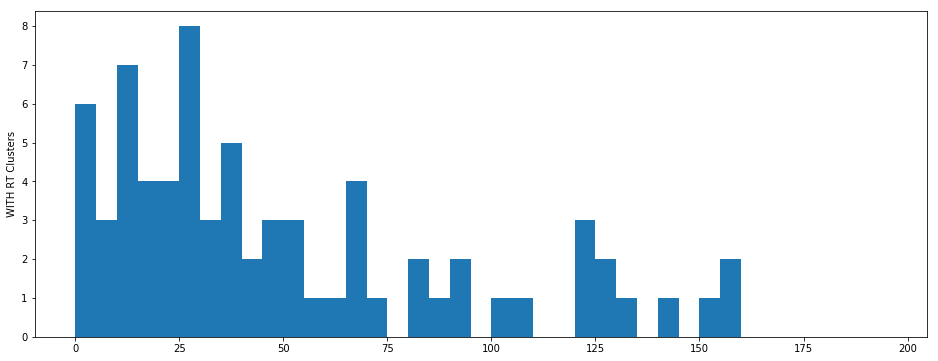

In [417]:
plt.figure(figsize=(16,6))
plt.hist(compare_df['difference %'], bins=np.arange(0,200,5))
plt.ylabel('Without RT Clusters')
plt.show()

plt.figure(figsize=(16,6))
plt.hist(compare_df_RT['difference %'], bins=np.arange(0,200,5))
plt.ylabel('WITH RT Clusters')
plt.show()

In [305]:
# numpy quartiles
compare_df['difference %'].quantile([.1,.2,.25,.5,.75,.9])

0.10      18.274779
0.20      29.096228
0.25      34.016373
0.50      94.928582
0.75     369.606017
0.90    1612.353151
Name: difference %, dtype: float64

In [419]:
# numpy quartiles
compare_df_RT['difference %'].quantile([.1,.2,.25,.5,.75,.9])

0.10      11.436855
0.20      23.171768
0.25      26.959437
0.50      76.960559
0.75     400.602671
0.90    1703.175574
Name: difference %, dtype: float64

In [214]:
df_big_misses = pd.DataFrame()
for film in list(big_misses.index):
    print(df_bo_predictor.bomojo_url[film])

http://www.boxofficemojo.com/movies/?id=horsesoldiers2018.htm
http://www.boxofficemojo.com/movies/?page=main&id=theprogram2015.htm
http://boxofficemojo.com/movies/?page=main&id=coriolanus.htm
https://www.boxofficemojo.com/movies/?id=adamjones.htm
https://www.boxofficemojo.com/movies/?id=heartofthesea.htm
https://www.boxofficemojo.com/movies/?id=goodkill.htm
http://www.boxofficemojo.com/movies/?id=islandoflemurs.htm
https://www.boxofficemojo.com/movies/?id=readyplayerone.htm
http://www.boxofficemojo.com/movies/?id=loganlucky.htm
http://www.boxofficemojo.com/movies/?id=riddick.htm
https://www.boxofficemojo.com/movies/?id=smashed.htm
